# **MOMENTUM-BASED CRYPTOCURRENCY TRADING STRATEGY**

# 1) Analysis of Bitcoin Performance, and creation of signals

**Analysis Approach**

1. Data Preprocessing
- Load Bitcoin historical price data.
- Ensure no missing/null values.
- Convert dates into weekly intervals starting on Sunday.
- Aggregate data into weekly closing prices.

---

2. Normalizing Weekly Closing Price
To standardize the closing price, compute the **weekly mean ($\mu$)** and **standard deviation ($\sigma$)**:

$$
\text{Normalized Close Price} = \frac{\text{Close Price} - \mu}{\sigma}
$$

- This ensures all prices are standardized relative to their historical distribution.

---

3. Defining Signal Thresholds
We use the **normalized weekly closing price change** to generate trading signals:

- **Investment Appetite ($A\%$):** If the **current week's normalized close price** increases by **$A$ or more** compared to the previous week’s normalized close, **signal "Buy"** for next week.
- **Risk Threshold ($R\%$):** If the **current week's normalized close price** decreases by **$R$ or more** compared to the previous week's normalized close, **signal "Sell"** for next week.
- **Hold Condition:** If neither condition is met, **signal "Hold"** for next week.

---

4. Calculating Weekly Normalized Change
We compute the **weekly normalized change (%)** as:

$$
\text{Normalized Weekly Change (\%)} = \left( \frac{\text{Normalized Close Price (Current Week)} - \text{Normalized Close Price (Previous Week)}}{\text{Normalized Close Price (Previous Week)}} \right) \times 100
$$

- Compare against thresholds:
  - If **Normalized Weekly Change $\geq A\%$** → **Buy**
  - If **Normalized Weekly Change $\leq -R\%$** → **Sell**
  - Otherwise → **Hold**

---

5. Generating Trading Signals
- Assign **Buy, Hold, or Sell** signals based purely on **normalized price change**.
- Store signals alongside **normalized weekly close prices** for **backtesting**.

---

**Advantages of This Approach**
- Removes price scale bias, handling different Bitcoin price ranges.  
- Focuses purely on price momentum, avoiding external indicators.  
- Keeps decisions objective & systematic, by using normalization.

---

The decision to designate Sunday as the beginning of the trading week in this project is grounded in the operational dynamics of traditional and crypto markets. Stock markets, including the NASDAQ, officially close trading activities on Saturday due to settlement periods and limited weekend operations. Meanwhile, the cryptocurrency market operates continuously, 24/7, without any closures. Given the project's assumption that Bitcoin’s price action is partially influenced by the broader sentiment and performance of traditional financial markets particularly the NASDAQ, it is logical to define Sunday as the starting point of a new trading cycle. This approach ensures that any reactions to market developments over the prior week, including NASDAQ's performance and macroeconomic news, are captured immediately at the start of the crypto week. By anchoring the analysis on Sunday, the model aligns itself with a fresh market sentiment reset, facilitating more meaningful weekly momentum analysis for Bitcoin.

---

In [7]:
#Loading all Libraries here

import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import optuna
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from collections import Counter
from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

---

#### 1- Data Preprocessing

In [5]:
# Load bitcoin prices data, we will use static data from Kaggle data
# Source URL: https://www.kaggle.com/datasets/oscardavidperilla/historical-bitcoin-prices-btc?resource=download
# Data Downloaded on Feb 16th 2025


raw_bitcoin=pd.read_csv('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/Bitcoin_Hist_Data.csv')

raw_bitcoin

,open,high,low,close,volume,close_time,quote,takers_buy_base,takers_buy_quote
0,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-16 23:59:59.999000-05:00,2.023661e+05,35.160503,1.509525e+05
1,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 00:59:59.999000-05:00,1.003048e+05,21.448071,9.260828e+04
2,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 01:59:59.999000-05:00,3.128231e+04,4.802861,2.079532e+04
3,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 02:59:59.999000-05:00,1.924106e+04,2.602292,1.129135e+04
4,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 03:59:59.999000-05:00,4.239504e+03,0.814655,3.552747e+03
...,...,...,...,...,...,...,...,...,...
38456,41184.44,41723.87,41118.36,41604.58,1816.054560,2022-01-10 13:59:59.999000-05:00,7.523858e+07,968.387390,4.012530e+07
38457,41604.58,41698.07,41205.65,41297.15,1358.541170,2022-01-10 14:59:59.999000-05:00,5.637205e+07,690.382540,2.864461e+07
38458,41297.15,41779.46,41158.99,41714.72,1245.440490,2022-01-10 15:59:59.999000-05:00,5.161796e+07,642.619620,2.663620e+07
38459,41716.81,41985.00,41562.38,41714.13,1365.382650,2022-01-10 16:59:59.999000-05:00,5.703537e+07,724.557670,3.026707e+07


---

In [11]:
# Perform EDA

print(f" Display general information on features and their types:\n {raw_bitcoin.info()} \n\n")

print(f" Display general statistics on the data itself: \n {raw_bitcoin.describe()} \n\n")

print(f" Verify what is the status of nulls:\n {raw_bitcoin.isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38461 entries, 0 to 38460
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              38461 non-null  float64
 1   high              38461 non-null  float64
 2   low               38461 non-null  float64
 3   close             38461 non-null  float64
 4   volume            38461 non-null  float64
 5   close_time        38461 non-null  object 
 6   quote             38461 non-null  float64
 7   takers_buy_base   38461 non-null  float64
 8   takers_buy_quote  38461 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.6+ MB
 Display general information on features and their types:
 None 


 Display general statistics on the data itself: 
                open          high           low         close        volume  \
count  38461.000000  38461.000000  38461.000000  38461.000000  38461.000000   
mean   17589.002805  17696.560219  17473.314191 

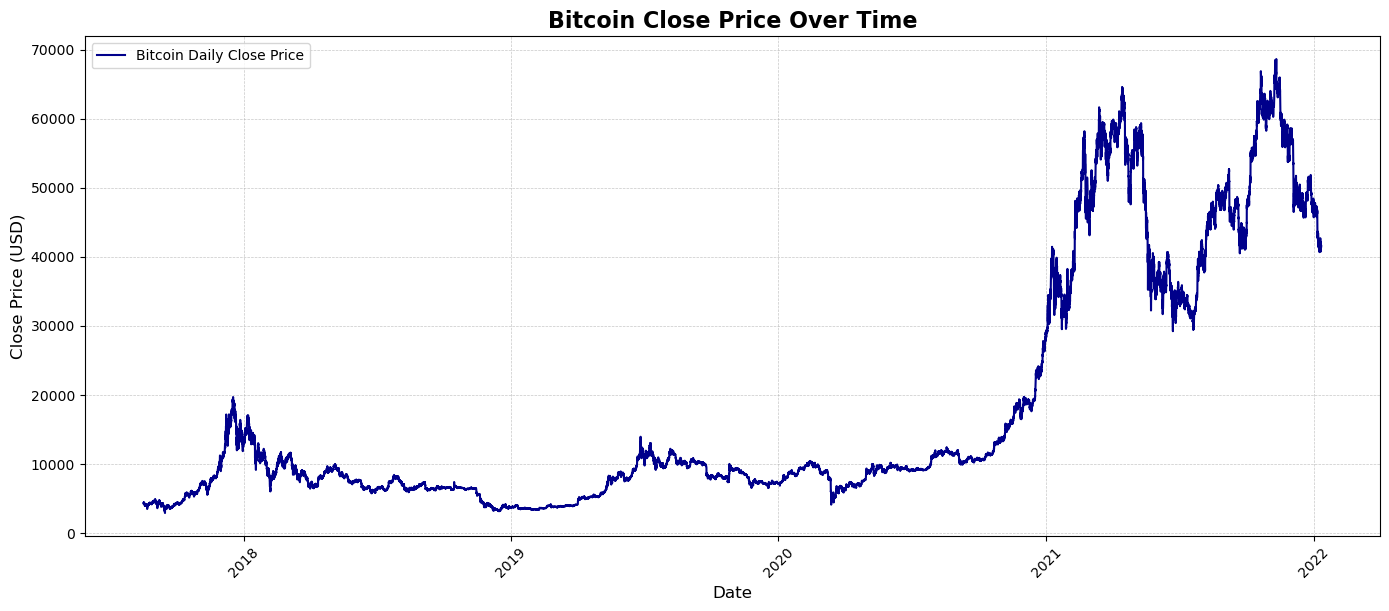

In [17]:
# time series plot for close vs close_time

# Ensure datetime format
raw_bitcoin['close_time'] = pd.to_datetime(raw_bitcoin['close_time'], format='mixed')

# Sort by time just in case
raw_bitcoin = raw_bitcoin.sort_values('close_time')


plt.figure(figsize=(14, 6))


# Plot the line and store the object
btc_line, = plt.plot(
    raw_bitcoin['close_time'],
    raw_bitcoin['close'],
    color='darkblue',
    linewidth=1.5,
    label='Bitcoin Daily Close Price'
)

# Add legend using the line object
plt.legend(handles=[btc_line], loc='upper left')

# Beautify the plot
plt.title('Bitcoin Close Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()

# Format x-axis with better date ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()

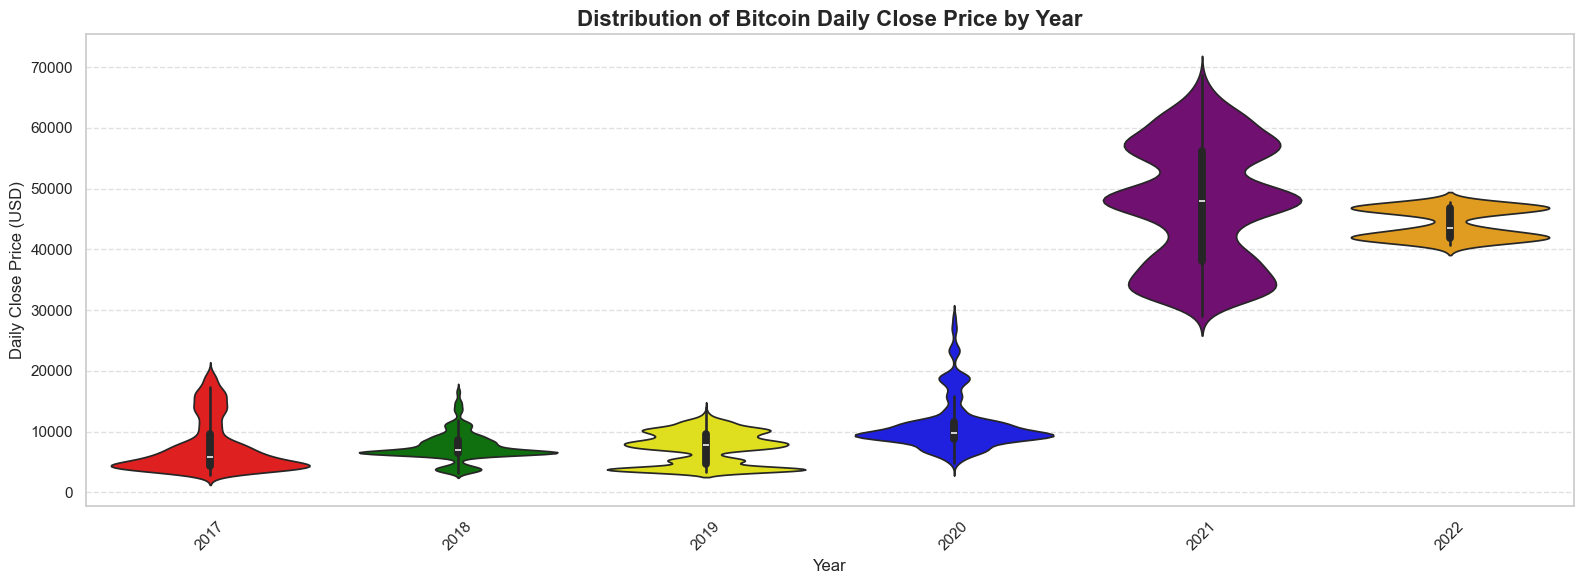

In [27]:
# we examine the annual distribution of close price

# Ensure datetime is correct and extract numeric year
raw_bitcoin['close_time'] = pd.to_datetime(raw_bitcoin['close_time'], format='mixed')
raw_bitcoin['year'] = raw_bitcoin['close_time'].dt.year.astype(str)  # Ensure year is string for categorical hue

# Get sorted list of unique years as strings
unique_years = sorted(raw_bitcoin['year'].unique())
custom_colors = ['red', 'green', 'yellow', 'blue', 'purple', 'orange'] * (len(unique_years) // 6 + 1)

# Map each year to a color
year_color_map = dict(zip(unique_years, custom_colors[:len(unique_years)]))

# Plot
plt.figure(figsize=(16, 6))
sns.violinplot(
    data=raw_bitcoin,
    x='year',
    y='close',
    hue='year',
    palette=year_color_map,
    inner='box',
    legend=False  # avoid duplicate legends since hue=x
)

# Labels and styling
plt.title('Distribution of Bitcoin Daily Close Price by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Daily Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

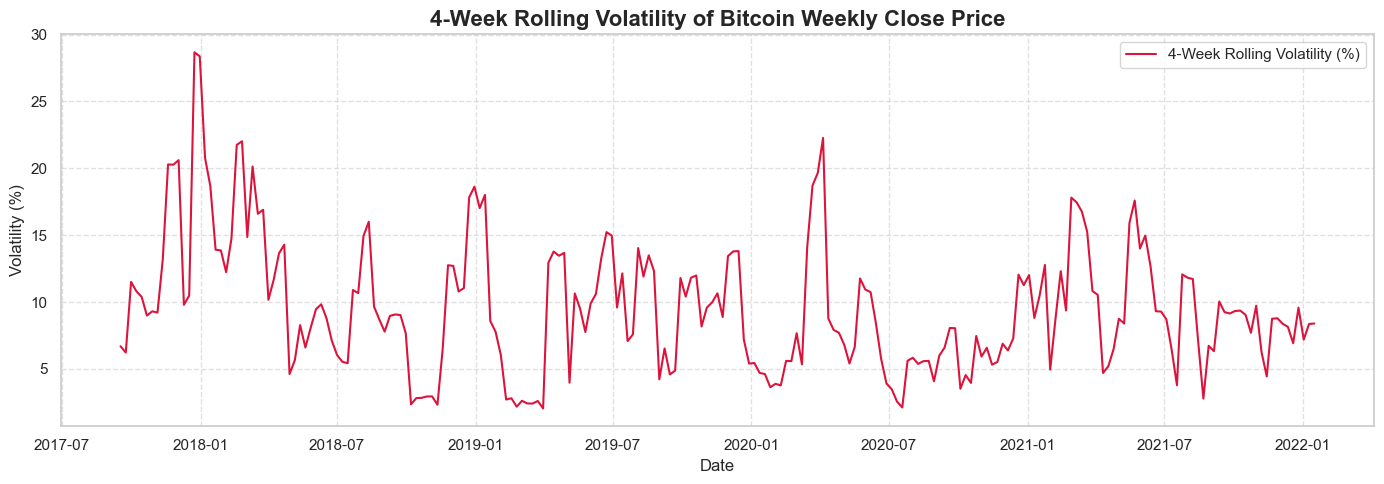

In [39]:
# we now plot rolling volatility to see how market volatility changes, helping explain model uncertainty and risk periods

# the rolling window will be resamples weekly, since our project targets weekly positioning strategy

# Set datetime column as index
bitcoin_weekly = raw_bitcoin.set_index('close_time')

# Resample to weekly close price (last value of each week)
weekly_close = bitcoin_weekly['close'].resample('W').last()

# Calculate 4-week rolling volatility (%)
weekly_volatility = weekly_close.pct_change().rolling(window=4).std() * 100

# Plot and assign the line to a variable
plt.figure(figsize=(14, 5))
vol_line, = plt.plot(
    weekly_volatility.index,
    weekly_volatility,
    color='crimson',
    linewidth=1.5,
    label='4-Week Rolling Volatility (%)'
)

# Add legend using the line handle
plt.legend(handles=[vol_line], loc='upper right')

# Styling
plt.title('4-Week Rolling Volatility of Bitcoin Weekly Close Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Exploratory Data Analysis Commentary

The exploratory data analysis (EDA) of Bitcoin’s historical close price reveals a highly dynamic, non-stationary, and volatile market behavior which is consistent with the cryptocurrency market's reputation for unpredictability.

### 1. Close Price Trend and Randomness
The long-term time series plot of Bitcoin’s daily close price demonstrates extended periods of low volatility followed by explosive upward or downward momentum. The sharp peaks observed in late 2017 and 2021, followed by steep corrections, highlight the **nonlinear and non-cyclical nature** of price movements. Such randomness is not purely stochastic but heavily driven by external, often exogenous, factors like global sentiment, policy shifts, or institutional adoption. This creates a major challenge for any predictive model, as momentum shifts are rarely gradual and often emerge abruptly.

### 2. Inter-Year Distribution of Price (Violin Plot)
The violin plots grouped by year visually confirm the **dramatic shifts in price distribution** across time. For example, from 2019 to 2021, Bitcoin's median and upper quartile values increased sharply, but so did the distribution's spread. The **widening tails and increasing number of outliers** in recent years signify an increasing degree of unpredictability and speculation. Each violin’s asymmetry and spread further emphasize that Bitcoin returns are not normally distributed, a trait that invalidates many traditional financial assumptions and reinforces the need for robust machine learning approaches that can handle skewed, heavy-tailed data.

### 3. Volatility Dynamics
The 4-week rolling volatility chart of weekly close prices is perhaps the most telling about market uncertainty. Volatility spikes, particularly around December 2017, March 2020, and May 2021, suggest periods of **price shock or regime change**. These bursts are not regular and have no seasonality, which reinforces the **irregular and sentiment-sensitive nature** of Bitcoin trading. The absence of a consistent volatility pattern weakens the assumptions of models that rely on constant variance or smooth seasonal behavior.

### 4. Statistical Summary
The summary statistics further support the complexity:
- The mean and standard deviation of prices are nearly equal (~17,500), indicating an extremely high **coefficient of variation**.
- The presence of minimum values at or near zero for several volume-based features (`volume`, `quote`, `takers_buy_base`) reflects **illiquid or idle trading days**, which could skew model signals if not handled carefully.
- The long-tailed distribution of the `quote` and `takers_buy_quote` columns suggest that a small number of days dominate overall trading activity—a common sign of **market clustering and imbalance**.

---

### Key Takeaway
The EDA reveals that Bitcoin's price is driven by a combination of **short-term sentiment, macroeconomic shocks, and speculative cycles**, all wrapped in a high-volatility environment. The **lack of stationarity, presence of fat tails, and abrupt structural shifts** present significant challenges for predictability. This complexity justifies the project’s use of **momentum-based strategies** and **multi-feature machine learning models** instead of naive or technical-indicator-only systems.

To forecast Buy/Hold/Sell positions effectively, the model must account for this **temporal unpredictability**, **event-driven volatility**, and **distributional irregularities**, making feature engineering and robust validation essential pillars of the project design.


---

In [13]:
# Now we start building historical bitcoin in the format that would work for our analysis

bitcoin=raw_bitcoin.copy().sort_values(by='close_time', ascending=True).drop(columns=['quote', 'takers_buy_base', 'takers_buy_quote']) # we make a copy of the raw data and make sure data is sorted

# Convert to datetime and extract only the date
# Ensure the column is treated as a string before conversion
bitcoin['Date'] = bitcoin['close_time'].astype(str) # added a separate column for date
bitcoin['close_time'] = bitcoin['close_time'].astype(str)

# Convert to datetime, allowing mixed formats
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], format='mixed', errors='coerce')
bitcoin['close_time'] = pd.to_datetime(bitcoin['close_time'], errors='coerce')

# Extract only the date
bitcoin['Date'] = bitcoin['Date'].dt.date

# Find the day of the date
bitcoin['Day'] = pd.to_datetime(bitcoin['Date']).dt.day_name()

# Extract only the time part
bitcoin['close_time'] = bitcoin['close_time'].dt.time

# Filter rows where time is '23:59:59.999000'
target_time = pd.to_datetime('23:59:59.999000').time()
bitcoin = bitcoin[bitcoin['close_time'] == target_time].reset_index(drop=True)

#Now we made sure we have the very last and most updated data for each day

# now we set the first day to be Monday and drop first 5 columns
bitcoin = bitcoin.drop(index=bitcoin.index[:5]).reset_index(drop=True)

# Ensure 'Date' is in datetime format
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

bitcoin['Week'] = bitcoin['Date'].dt.to_period('W-SUN')  # Create week group based on Sunday start

# Compute weekly mean and standard deviation of closing prices
weekly_stats = bitcoin.groupby('Week')['close'].agg(['mean', 'std']).reset_index()
weekly_stats.rename(columns={'mean': 'weekly_mean', 'std': 'weekly_std'}, inplace=True)

# Merge stats back to the original dataframe
bitcoin = bitcoin.merge(weekly_stats, on='Week', how='left')

# Normalize closing prices only for Saturdays
bitcoin['Normalized_Close'] = (bitcoin['close'] - bitcoin['weekly_mean']) / bitcoin['weekly_std']
bitcoin.loc[bitcoin['Day'] != 'Saturday', 'Normalized_Close'] = None  # Keep only Saturday values

# now we cleanse the dataframe and only keep the week group with the normalized close
bitcoin_cleansed = bitcoin[['Week', 'Normalized_Close']].dropna().reset_index(drop=True)

#bitcoin.head(50)
bitcoin_cleansed.tail()

,Week,Normalized_Close
222,2021-12-06/2021-12-12,-0.505386
223,2021-12-13/2021-12-19,0.362223
224,2021-12-20/2021-12-26,0.180187
225,2021-12-27/2022-01-02,-0.498080
226,2022-01-03/2022-01-09,-0.621754


In [20]:
# now we create weekly signals, based on appetite and risk threshould

appetite=15 # % increase threshould for buy
risk=5 # % decrease threshould for sell

# Compute next week's percentage change
bitcoin_cleansed['Next_Week_Change'] = bitcoin_cleansed['Normalized_Close'].shift(-1) - bitcoin_cleansed['Normalized_Close']

# Convert to percentage change
bitcoin_cleansed['Next_Week_Change'] = (bitcoin_cleansed['Next_Week_Change'] / bitcoin_cleansed['Normalized_Close']) * 100

# Function to classify signals
def classify_signal(change):
    
    if change >= appetite:
        return "Buy"
    elif change <= -risk:
        return "Sell"
    else:
        return "Hold"

# Apply classification function
bitcoin_cleansed['Next_Week_Signal'] = bitcoin_cleansed['Next_Week_Change'].apply(classify_signal)

bitcoin_cleansed.drop(columns=['Next_Week_Change'], inplace=True)


bitcoin_cleansed

,Week,Normalized_Close,Next_Week_Signal
0,2017-08-21/2017-08-27,0.704788,Hold
1,2017-08-28/2017-09-03,0.680969,Sell
2,2017-09-04/2017-09-10,-0.844462,Sell
3,2017-09-11/2017-09-17,-0.756660,Buy
4,2017-09-18/2017-09-24,-1.199885,Sell
...,...,...,...
222,2021-12-06/2021-12-12,-0.505386,Sell
223,2021-12-13/2021-12-19,0.362223,Sell
224,2021-12-20/2021-12-26,0.180187,Sell
225,2021-12-27/2022-01-02,-0.498080,Buy


# 2) Analysis of Bitcoin On-Chain Metrics

#### Total Hashrate (TH/s)

Mining hashrate serves as a fundamental security measure for the Bitcoin network. A higher hashrate signifies greater computational power dedicated to mining, enhancing network security and making it more resistant to attacks. While Bitcoin’s exact hashrate remains unknown, it can be estimated based on the number of blocks mined and the prevailing block difficulty.

Each Bitcoin node constructs its own mempool by connecting to the Bitcoin network, maintaining a unique view of unconfirmed transactions. At Blockchain.com, mempool data is aggregated from multiple up-to-date Bitcoin nodes, ensuring a comprehensive and accurate representation of mempool activity. This approach maximizes visibility into transaction propagation across the network.

Due to the inherent randomness of block discovery, daily hashrate estimates may fluctuate, even when overall mining power remains constant. As a result, short-term variations in block production are not necessarily indicative of fundamental changes in mining activity. A 7-day moving average provides a more reliable indicator of the network’s true computational strength, smoothing out these fluctuations for a clearer trend analysis.

In [33]:
# Load total HR data, we will use static data from blockchain.com
# Source URL: https://www.blockchain.com/explorer/charts/hash-rate
# Data Downloaded on Feb 23rd 2025

# Open and read the JSON file
with open('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/hash-rate.json', 'r') as file:
    raw_HR_jsn = json.load(file)

# Convert to DataFrame
raw_HR = pd.DataFrame(raw_HR_jsn["hash-rate"])

# Convert 'x' from Unix timestamp (milliseconds) to datetime
raw_HR["Date"] = pd.to_datetime(raw_HR["x"], unit="ms")

# Rename columns for clarity
raw_HR = raw_HR.rename(columns={"y": "Hash Rate (TH/s)"})

# Drop original Unix timestamp column
raw_HR = raw_HR.drop(columns=["x"])

# Filter data within the historic bitcoin data date range
raw_HR = raw_HR[(raw_HR["Date"] >= "2017-08-03") & (raw_HR["Date"] < "2022-01-10")]

raw_HR

,Hash Rate (TH/s),Date
784,7.568850e+06,2017-08-05
785,6.333395e+06,2017-08-09
786,6.792336e+06,2017-08-13
787,8.215055e+06,2017-08-17
788,5.277829e+06,2017-08-21
...,...,...
1184,1.780076e+08,2021-12-22
1185,1.616823e+08,2021-12-26
1186,1.435835e+08,2021-12-30
1187,1.689218e+08,2022-01-03


Unlike what is mentioned on the datasource, data are not in a fixed 1 week sampling and the intervals in days vary, this needs to be adressed and fixed before proceeding, such that we create a weekly moving average of data - as mentioned in the methodology section of blockchain.com, and I will take one more step to have moving average of normalized data

In [35]:

# create a copy of the raw data to be cleansed

HR=raw_HR.copy()

# apply min-max normalization for each week and resample data in one go
HR = HR.set_index("Date").resample("W").apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).mean() if x.max() != x.min() else 0
).reset_index()

# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
HR["Week"] = (HR["Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + HR["Date"].dt.strftime("%Y-%m-%d")

# Apply a moving average 
HR["Hash Rate (TH/s) 3-Week Moving Average"] = HR["Hash Rate (TH/s)"].rolling(window=3).mean()

# drop the first 3 columns to match starting week of bitcoin historic data
HR=HR.iloc[3:].reset_index(drop=True)

HR_cleansed=HR.drop(columns=["Date", "Hash Rate (TH/s)"])

HR_cleansed

,Week,Hash Rate (TH/s) 3-Week Moving Average
0,2017-08-21/2017-08-27,0.333333
1,2017-08-28/2017-09-03,0.333333
2,2017-09-04/2017-09-10,0.500000
3,2017-09-11/2017-09-17,0.333333
4,2017-09-18/2017-09-24,0.333333
...,...,...
224,2021-12-06/2021-12-12,0.333333
225,2021-12-13/2021-12-19,0.333333
226,2021-12-20/2021-12-26,0.500000
227,2021-12-27/2022-01-02,0.333333


#### Mempool Growth B/s (Bytes Per Second)

The mempool is a temporary holding area for all valid Bitcoin transactions that are awaiting confirmation by the network. When transaction volume is high, the mempool becomes congested, leading to longer confirmation times and increased priority fees as users compete for block space.

The mempool count metric provides insight into how many transactions are contributing to the congestion, while the {mempoolsize} chart serves as a more reliable indicator of how long the congestion may persist.

For a transaction to be confirmed, it must be included in a block. However, while the maximum block size is fixed, the number of transactions that fit within a block varies. This is because transactions differ in size based on their complexity and data payload.

Each Bitcoin node maintains its own version of the mempool by continuously syncing with the Bitcoin network. To ensure accuracy, Blockchain.com aggregates mempool data from multiple up-to-date Bitcoin nodes maintained by its engineering team. This approach allows for a more comprehensive and precise representation of mempool activity, helping users gauge network congestion more effectively.

Higher mempool corresponds to higher transaction fees across platforms, potentionall discouraging transactions until transfer time goes down.

In [37]:
# Load total mempool data, we will use static data from blockchain.com
# Source URL: https://www.blockchain.com/explorer/charts/mempool-growth
# Data Downloaded on Feb 23rd 2025



# Open and read the JSON file
with open('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/mempool-growth.json', 'r') as file:
    raw_mem_jsn = json.load(file)

# Convert to DataFrame
raw_mem = pd.DataFrame(raw_mem_jsn["mempool-growth"])

# Convert 'x' from Unix timestamp (milliseconds) to datetime
raw_mem["Date"] = pd.to_datetime(raw_mem["x"], unit="ms")

# Rename columns for clarity
raw_mem = raw_mem.rename(columns={"y": "Growth Rate (B/s)"})

# Drop original Unix timestamp column
raw_mem = raw_mem.drop(columns=["x"])

# Filter data within the historic bitcoin data date range
raw_mem = raw_mem[(raw_mem["Date"] >= "2017-08-21") & (raw_mem["Date"] < "2022-01-10")]

# create a copy of the raw data to be cleansed

mem=raw_mem.copy()

# apply min-max normalization
mem = mem.set_index("Date").resample("W").apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).mean() if x.max() != x.min() else 0
).reset_index()


# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
mem["Week"] = (mem["Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + mem["Date"].dt.strftime("%Y-%m-%d")

# Organise the DF a bit 

mem_cleansed=mem.drop(columns=["Date","Growth Rate (B/s)"])

mem_cleansed["Growth Rate (B/s)"]=mem["Growth Rate (B/s)"] 

mem_cleansed

,Week,Growth Rate (B/s)
0,2017-08-21/2017-08-27,0.531859
1,2017-08-28/2017-09-03,0.451974
2,2017-09-04/2017-09-10,0.542627
3,2017-09-11/2017-09-17,0.526170
4,2017-09-18/2017-09-24,0.553261
...,...,...
224,2021-12-06/2021-12-12,0.587320
225,2021-12-13/2021-12-19,0.449212
226,2021-12-20/2021-12-26,0.410243
227,2021-12-27/2022-01-02,0.502229


#### Unique Addresses Used

The Unique Addresses Used metric provides a fundamental insight into Bitcoin network activity by tracking the number of distinct addresses involved in transactions within a given time frame. It serves as a strong indicator of on-chain usage, reflecting user engagement and adoption levels.

A high number of unique addresses suggests increased network activity, often correlated with rising demand for Bitcoin transactions. Conversely, a decline may indicate reduced user participation or a shift in transaction behavior, such as increased coin consolidation by large holders.

Unlike transaction count, which can be influenced by batching and automated activity, unique addresses give a clearer picture of individual network participants. However, due to the nature of Bitcoin’s address system—where users often generate new addresses for privacy—this metric does not equate directly to unique users.

In [39]:
# Load total mempool data, we will use static data from blockchain.com
# Source URL: https://www.blockchain.com/explorer/charts/n-unique-addresses
# Data Downloaded on Feb 23rd 2025



# Open and read the JSON file
with open('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/n-unique-addresses.json', 'r') as file:
    raw_uaddress_jsn = json.load(file)

# Convert to DataFrame
raw_uaddress = pd.DataFrame(raw_uaddress_jsn["n-unique-addresses"])

# Convert 'x' from Unix timestamp (milliseconds) to datetime
raw_uaddress["Date"] = pd.to_datetime(raw_uaddress["x"], unit="ms")

# Rename columns for clarity
raw_uaddress = raw_uaddress.rename(columns={"y": "Number of Unique Addresses"})

# Drop original Unix timestamp column
raw_uaddress = raw_uaddress.drop(columns=["x"])

# Filter data within the historic bitcoin data date range
raw_uaddress = raw_uaddress[(raw_uaddress["Date"] >= "2017-08-21") & (raw_uaddress["Date"] < "2022-01-10")]

# create a copy of the raw data to be cleansed

uaddress=raw_uaddress.copy()

# apply min-max normalization
uaddress = uaddress.set_index("Date").resample("W").apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).mean() if x.max() != x.min() else 0
).reset_index()


# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
uaddress["Week"] = (uaddress["Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + uaddress["Date"].dt.strftime("%Y-%m-%d")

# Organise the DF a bit 
uaddress_cleansed=uaddress.drop(columns=["Date","Number of Unique Addresses"])

uaddress_cleansed["Number of Unique Addresses"]=uaddress["Number of Unique Addresses"] 

uaddress_cleansed

,Week,Number of Unique Addresses
0,2017-08-21/2017-08-27,0.0
1,2017-08-28/2017-09-03,0.5
2,2017-09-04/2017-09-10,0.5
3,2017-09-11/2017-09-17,0.5
4,2017-09-18/2017-09-24,0.0
...,...,...
224,2021-12-06/2021-12-12,0.5
225,2021-12-13/2021-12-19,0.0
226,2021-12-20/2021-12-26,0.5
227,2021-12-27/2022-01-02,0.5


#### Average Block Size (MB)

The Average Block Size metric reflects the average amount of data, measured in megabytes (MB), that Bitcoin miners successfully add to the blockchain per block. This metric serves as a key indicator of network utilization, transaction volume, and block space demand.

A larger average block size suggests higher transaction activity, often due to increased network demand or larger transaction sizes. Conversely, smaller blocks indicate periods of lower transaction volume or greater efficiency in transaction batching. While Bitcoin's maximum block size is capped at 4MB (with SegWit optimizations), the actual block size fluctuates based on miner incentives and network congestion.

Since blocks are added approximately every 10 minutes, monitoring the average block size helps assess network scalability and congestion. Persistent high block sizes may lead to increased fees and longer confirmation times, prompting users to prioritize transactions with higher fees.

In [41]:
# Load total mempool data, we will use static data from blockchain.com
# Source URL: https://www.blockchain.com/explorer/charts/avg-block-size
# Data Downloaded on Feb 23rd 2025



# Open and read the JSON file
with open('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/avg-block-size.json', 'r') as file:
    raw_blocksize_jsn = json.load(file)

# Convert to DataFrame
raw_blocksize = pd.DataFrame(raw_blocksize_jsn["avg-block-size"])

# Convert 'x' from Unix timestamp (milliseconds) to datetime
raw_blocksize["Date"] = pd.to_datetime(raw_blocksize["x"], unit="ms")

# Rename columns for clarity
raw_blocksize = raw_blocksize.rename(columns={"y": "Average Block Size (MB)"})

# Drop original Unix timestamp column
raw_blocksize = raw_blocksize.drop(columns=["x"])

# Filter data within the historic bitcoin data date range
raw_blocksize = raw_blocksize[(raw_blocksize["Date"] >= "2017-08-21") & (raw_blocksize["Date"] < "2022-01-10")]

# create a copy of the raw data to be cleansed

blocksize=raw_blocksize.copy()

# apply min-max normalization
blocksize = blocksize.set_index("Date").resample("W").apply(
    lambda x: ((x - x.min()) / (x.max() - x.min())).mean() if x.max() != x.min() else 0
).reset_index()


# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
blocksize["Week"] = (blocksize["Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + blocksize["Date"].dt.strftime("%Y-%m-%d")

# Organise the DF a bit 
blocksize_cleansed=blocksize.drop(columns=["Date","Average Block Size (MB)"])

blocksize_cleansed["Average Block Size (MB)"]=blocksize["Average Block Size (MB)"] 

blocksize_cleansed

,Week,Average Block Size (MB)
0,2017-08-21/2017-08-27,0.5
1,2017-08-28/2017-09-03,0.5
2,2017-09-04/2017-09-10,0.0
3,2017-09-11/2017-09-17,0.5
4,2017-09-18/2017-09-24,0.5
...,...,...
224,2021-12-06/2021-12-12,0.5
225,2021-12-13/2021-12-19,0.5
226,2021-12-20/2021-12-26,0.0
227,2021-12-27/2022-01-02,0.5


### Market Indicators

We will use NASDAQ as an indicator to stock market health, hypothetically speaking, stock market and crypto market should balance out with each other

In [43]:
#!pip install yfinance

import yfinance as yf

# Define the NASDAQ Composite Index ticker
ticker = "^IXIC"

# Download historical data
nasdaq_raw = yf.download(ticker, start="2017-08-21", end="2022-01-10", interval="1d")

nasdaq_raw

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^IXIC,^IXIC,^IXIC,^IXIC,^IXIC
Date,,,,,
2017-08-21,6213.129883,6226.930176,6177.189941,6216.319824,1582990000
2017-08-22,6297.479980,6302.839844,6241.209961,6241.209961,1599760000
2017-08-23,6278.410156,6291.299805,6263.290039,6263.470215,1535320000
2017-08-24,6271.330078,6302.850098,6244.569824,6294.819824,1618660000
2017-08-25,6265.640137,6308.720215,6257.100098,6293.810059,1445590000
...,...,...,...,...,...
2022-01-03,15832.799805,15832.799805,15644.089844,15732.500000,4429960000
2022-01-04,15622.719727,15852.139648,15512.410156,15852.139648,5131110000


In [45]:
nasdaq_raw = nasdaq_raw.reset_index()

In [47]:

# Reset index to remove the 'Ticker' row and set Date as index
nasdaq = nasdaq_raw.rename(columns={"^IXIC": "Close"}).set_index("Date")

# Rename remaining columns correctly
nasdaq.columns = ["Close", "High", "Low", "Open", "Volume"]

nasdaq = nasdaq.reset_index().reset_index(drop=True)

nasdaq.columns = nasdaq.columns.str.strip()


nasdaq

,Date,Close,High,Low,Open,Volume
0,2017-08-21,6213.129883,6226.930176,6177.189941,6216.319824,1582990000
1,2017-08-22,6297.479980,6302.839844,6241.209961,6241.209961,1599760000
2,2017-08-23,6278.410156,6291.299805,6263.290039,6263.470215,1535320000
3,2017-08-24,6271.330078,6302.850098,6244.569824,6294.819824,1618660000
4,2017-08-25,6265.640137,6308.720215,6257.100098,6293.810059,1445590000
...,...,...,...,...,...,...
1100,2022-01-03,15832.799805,15832.799805,15644.089844,15732.500000,4429960000
1101,2022-01-04,15622.719727,15852.139648,15512.410156,15852.139648,5131110000
1102,2022-01-05,15100.169922,15586.299805,15095.179688,15547.160156,5031850000
1103,2022-01-06,15080.860352,15198.450195,14914.870117,15024.150391,4790820000


We will use a similar approach to normalizing closing values of the week as we did with bitcoin

In [49]:
nasdaq = nasdaq.reset_index(drop=True)


# Ensure 'Date' is in datetime format
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])

# Find the day of the date
nasdaq['Day'] = pd.to_datetime(nasdaq['Date']).dt.day_name()

nasdaq['Week'] = nasdaq['Date'].dt.to_period('W-SUN')  # Create week group based on Sunday start

# Compute weekly mean and standard deviation of closing prices
weekly_stats = nasdaq.groupby('Week')['Close'].agg(['mean', 'std']).reset_index()
weekly_stats.rename(columns={'mean': 'weekly_mean', 'std': 'weekly_std'}, inplace=True)

# Merge stats back to the original dataframe
nasdaq = nasdaq.merge(weekly_stats, on='Week', how='left')

# Normalize closing prices only for Saturdays
nasdaq['Normalized_Close'] = (nasdaq['Close'] - nasdaq['weekly_mean']) / nasdaq['weekly_std']

nasdaq.loc[nasdaq['Day'] != 'Friday', 'Normalized_Close'] = None  # Keep only Friday being last day of the week

# now we cleanse the dataframe and only keep the week group with the normalized close
nasdaq_cleansed = nasdaq[['Week', 'Normalized_Close']].dropna().reset_index(drop=True)

nasdaq_cleansed

,Week,Normalized_Close
0,2017-08-21/2017-08-27,0.014041
1,2017-08-28/2017-09-03,1.024327
2,2017-09-04/2017-09-10,-1.246314
3,2017-09-11/2017-09-17,0.264913
4,2017-09-18/2017-09-24,-0.964002
...,...,...
216,2021-11-29/2021-12-05,-1.207730
217,2021-12-06/2021-12-12,0.283689
218,2021-12-13/2021-12-19,-0.837571
219,2021-12-27/2022-01-02,-1.428550


### Analysis of Major World Events

The focus is on any major world event that had an effect on a global level, on the americas, Europe, and the middle east

In [51]:
# Load major world events data
# Source URL: https://www.kaggle.com/datasets/saketk511/world-important-events-ancient-to-modern 
# Data Downloaded on Jan 24th 2025

events_raw=pd.read_csv('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/World Important Dates.csv')

#delete any row that we dont know the exact date for it
events_raw = events_raw.loc[events_raw["Month"] != "Unknown"]

# create a formatted date
events_raw["Formatted_Date"] = pd.to_datetime(
    events_raw["Year"].astype(str) + "-" + events_raw["Month"] + "-" + events_raw["Date"].astype(str),
    format="%Y-%B-%d",
    errors="coerce"  # This will handle invalid dates by setting them to NaT
)

# Convert to "YYYY-MM-DD" string format
events_raw["Formatted_Date"] = events_raw["Formatted_Date"].dt.strftime("%Y-%m-%d")

# Filter data within the historic bitcoin data date range
events_raw = events_raw[(events_raw["Formatted_Date"] >= "2017-08-21") & (events_raw["Formatted_Date"] < "2022-01-10")]

# sort on the formatted date
events_raw = events_raw.sort_values(by="Formatted_Date", ascending=True)

# Define the list of substrings
keywords = ["America", "Global", "Middle East", "Europe", "Saudi"]

# Create a regex pattern using '|'. This means "America OR Global OR Middle East OR Europe"
pattern = "|".join(keywords)

# Filter rows where the column contains any of the substrings
events = events_raw[events_raw["Affected Population"].str.contains(pattern, case=False, na=False)]

# encode outcome such that negatives get negative values, positive are positive and neutrals are 0
# Define a custom encoding mapping
sentiment_mapping = {
    
    "Negative": -1,
    "Mixed": 0,
    "Positive": 1,
    
}

events = events.copy()

# Apply the mapping to the column
events["Events Sentiment"] = events["Outcome"].map(sentiment_mapping)

# Create a column with 1's indicating presence of a major world event
events["Number of Major Events"] = 1

# Ensure Formatted_Date is in datetime format
events["Formatted_Date"] = pd.to_datetime(events["Formatted_Date"])

# Resample by week, summing the sentiment and event count
weekly_events = events.set_index("Formatted_Date").resample("W").agg({
    "Events Sentiment": "sum",
    "Number of Major Events": "sum"
}).reset_index()

# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
weekly_events["Week"] = (weekly_events["Formatted_Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + weekly_events["Formatted_Date"].dt.strftime("%Y-%m-%d")

weekly_events = weekly_events.drop(columns=["Formatted_Date"])

# Move Week column to the first position
cols = ["Week"] + [col for col in weekly_events.columns if col != "Week"]
weekly_events = weekly_events[cols]

weekly_events.head()

,Week,Events Sentiment,Number of Major Events
0,2017-10-30/2017-11-05,0,2
1,2017-11-06/2017-11-12,1,1
2,2017-11-13/2017-11-19,0,0
3,2017-11-20/2017-11-26,0,0
4,2017-11-27/2017-12-03,0,0


### Economic Indicators

In [53]:
# Load economic indicators data
# Source URL: https://www.kaggle.com/datasets/heidarmirhajisadati/global-economic-indicators-dataset-2010-2023
# Data Downloaded on Feb 23rd 2025

economy_raw=pd.read_csv('/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/economic_indicators_dataset_2010_2023.csv')

#filter for USA
economy_raw = economy_raw.loc[economy_raw["Country"] == "USA"]

# Ensure 'Date' is in datetime format
economy_raw['Date'] = pd.to_datetime(economy_raw['Date'])

# sort on the formatted date
economy_raw = economy_raw.sort_values(by="Date", ascending=True)

# Filter data within the historic bitcoin data date range
economy_raw = economy_raw[(economy_raw["Date"] >= "2017-06-01") & (economy_raw["Date"] < "2022-01-10")]

# Define the start and end date
start_date = "2017-08-21"
end_date = "2022-01-09"

# Create a complete weekly date range
weekly_dates = pd.date_range(start=start_date, end=end_date, freq="W")

economy=economy_raw.copy()

# Convert existing Date column to datetime format
economy["Date"] = pd.to_datetime(economy["Date"])

# Remove duplicates while keeping the row with the highest 'Inflation Rate (%)' for each date
economy = economy.loc[economy.groupby("Date")["Inflation Rate (%)"].idxmax()]

# Set Date as the index
economy = economy.set_index("Date")

# Reindex the dataset to include all weekly dates
economy = economy.reindex(weekly_dates, method='ffill')  # Forward fill missing data

# Reset index and rename the new Date column
economy = economy.reset_index().rename(columns={"index": "Date"})

# Create the week range column in "YYYY-MM-DD/YYYY-MM-DD" format
economy["Week"] = (economy["Date"] + pd.DateOffset(days=-6)).dt.strftime("%Y-%m-%d") + "/" + economy["Date"].dt.strftime("%Y-%m-%d")

# Drop the 'Date' and 'Country' columns
economy_cleansed = economy.drop(columns=["Date", "Country"])

# Move the 'Week' column to the first position
cols = ["Week"] + [col for col in economy_cleansed.columns if col != "Week"]
economy_cleansed = economy_cleansed[cols]

economy_cleansed

,Week,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2017-08-21/2017-08-27,7.71,4.1,4.33,9.44,29958.70
1,2017-08-28/2017-09-03,7.71,4.1,4.33,9.44,29958.70
2,2017-09-04/2017-09-10,7.71,4.1,4.33,9.44,29958.70
3,2017-09-11/2017-09-17,7.71,4.1,4.33,9.44,29958.70
4,2017-09-18/2017-09-24,7.71,4.1,4.33,9.44,29958.70
...,...,...,...,...,...,...
224,2021-12-06/2021-12-12,0.53,4.7,2.98,0.11,6613.73
225,2021-12-13/2021-12-19,0.53,4.7,2.98,0.11,6613.73
226,2021-12-20/2021-12-26,0.53,4.7,2.98,0.11,6613.73
227,2021-12-27/2022-01-02,0.53,4.7,2.98,0.11,6613.73


# 3) Construction of Project Dataset

In [55]:
# Create an empty DataFrame with unique "Week" values
data = pd.DataFrame(sorted(HR_cleansed["Week"].astype(str).unique()), columns=["Week"])

# Merge HR_cleansed first
data = data.merge(HR_cleansed, on="Week", how="left")

# Ensure Week column in bitcoin_cleansed is also a string
bitcoin_cleansed["Week"] = bitcoin_cleansed["Week"].astype(str)

# Merge bitcoin_cleansed with forward fill, bitcoin_cleansed has 2 missing weeks without forward fill they will be null
data = data.merge(bitcoin_cleansed, on="Week", how="left").ffill()

# Ensure Week column in nasdaq_cleansed is also a string
nasdaq_cleansed["Week"] = nasdaq_cleansed["Week"].astype(str)

# Merge nasdaq_cleansed with forward fill
data = data.merge(nasdaq_cleansed, on="Week", how="left").ffill()

# Ensure Week column in weekly_events is also a string
weekly_events["Week"] = weekly_events["Week"].astype(str)

# Merge weekly_events and fill nulls with zeros
data = data.merge(weekly_events, on="Week", how="left").fillna(0)

# Ensure Week column in mem_cleansed is also a string
mem_cleansed["Week"] = mem_cleansed["Week"].astype(str)

# Merge mem_cleansed 
data = data.merge(mem_cleansed, on="Week", how="left")

# Ensure Week column in uaddress_cleansed is also a string
uaddress_cleansed["Week"] = uaddress_cleansed["Week"].astype(str)

# Merge uaddress_cleansed 
data = data.merge(uaddress_cleansed, on="Week", how="left")

# Ensure Week column in blocksize_cleansed is also a string
blocksize_cleansed["Week"] = blocksize_cleansed["Week"].astype(str)

# Merge blocksize_cleansed 
data = data.merge(blocksize_cleansed, on="Week", how="left")

# Ensure Week column in economy_cleansed is also a string
economy_cleansed["Week"] = economy_cleansed["Week"].astype(str)

# Merge economy_cleansed 
data = data.merge(economy_cleansed, on="Week", how="left")

# Rename the columns after merging
data = data.rename(columns={"Normalized_Close_x": "Normalized Bitcoin Week Close"})
data = data.rename(columns={"Next_Week_Signal": "Next Week Bitcoin Signal"})
data = data.rename(columns={"Normalized_Close_y": "Normalized NASDAQ Week Close"})

data

,Week,Hash Rate (TH/s) 3-Week Moving Average,Normalized Bitcoin Week Close,Next Week Bitcoin Signal,Normalized NASDAQ Week Close,Events Sentiment,Number of Major Events,Growth Rate (B/s),Number of Unique Addresses,Average Block Size (MB),Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2017-08-21/2017-08-27,0.333333,0.704788,Hold,0.014041,0.0,0.0,0.531859,0.0,0.5,7.71,4.1,4.33,9.44,29958.70
1,2017-08-28/2017-09-03,0.333333,0.680969,Sell,1.024327,0.0,0.0,0.451974,0.5,0.5,7.71,4.1,4.33,9.44,29958.70
2,2017-09-04/2017-09-10,0.500000,-0.844462,Sell,-1.246314,0.0,0.0,0.542627,0.5,0.0,7.71,4.1,4.33,9.44,29958.70
3,2017-09-11/2017-09-17,0.333333,-0.756660,Buy,0.264913,0.0,0.0,0.526170,0.5,0.5,7.71,4.1,4.33,9.44,29958.70
4,2017-09-18/2017-09-24,0.333333,-1.199885,Sell,-0.964002,0.0,0.0,0.553261,0.0,0.5,7.71,4.1,4.33,9.44,29958.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2021-12-06/2021-12-12,0.333333,-0.505386,Sell,0.283689,0.0,0.0,0.587320,0.5,0.5,0.53,4.7,2.98,0.11,6613.73
225,2021-12-13/2021-12-19,0.333333,0.362223,Sell,-0.837571,0.0,0.0,0.449212,0.0,0.5,0.53,4.7,2.98,0.11,6613.73
226,2021-12-20/2021-12-26,0.500000,0.180187,Sell,-0.837571,1.0,1.0,0.410243,0.5,0.0,0.53,4.7,2.98,0.11,6613.73
227,2021-12-27/2022-01-02,0.333333,-0.498080,Buy,-1.428550,0.0,0.0,0.502229,0.5,0.5,0.53,4.7,2.98,0.11,6613.73


In [96]:
# We adjust the dataset some more here

# we start by manually encoding weekly signals:
signal_mapping = {"Buy": 1, "Hold": 0, "Sell": -1}

# Encode the "Next Week Bitcoin Signal" column
data["Next Week Bitcoin Signal"] = data["Next Week Bitcoin Signal"].map(signal_mapping)

# Move "Next Week Bitcoin Signal" right after "Week"
cols = ["Week", "Next Week Bitcoin Signal"] + [col for col in data.columns if col not in ["Week", "Next Week Bitcoin Signal"]]

# Reorder DataFrame
data = data[cols]

data

,Week,Next Week Bitcoin Signal,Hash Rate (TH/s) 3-Week Moving Average,Normalized Bitcoin Week Close,Normalized NASDAQ Week Close,Events Sentiment,Number of Major Events,Growth Rate (B/s),Number of Unique Addresses,Average Block Size (MB),Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2017-08-21/2017-08-27,0,0.333333,0.704788,0.014041,0.0,2.0,0.531859,0.0,0.5,7.71,4.1,4.33,9.44,29958.70
1,2017-08-28/2017-09-03,-1,0.333333,0.680969,1.024327,1.0,1.0,0.451974,0.5,0.5,7.71,4.1,4.33,9.44,29958.70
2,2017-09-04/2017-09-10,-1,0.500000,-0.844462,-1.246314,0.0,0.0,0.542627,0.5,0.0,7.71,4.1,4.33,9.44,29958.70
3,2017-09-11/2017-09-17,1,0.333333,-0.756660,0.264913,0.0,0.0,0.526170,0.5,0.5,7.71,4.1,4.33,9.44,29958.70
4,2017-09-18/2017-09-24,-1,0.333333,-1.199885,-0.964002,0.0,0.0,0.553261,0.0,0.5,7.71,4.1,4.33,9.44,29958.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2021-12-06/2021-12-12,-1,0.333333,-0.505386,0.283689,0.0,0.0,0.587320,0.5,0.5,0.53,4.7,2.98,0.11,6613.73
225,2021-12-13/2021-12-19,-1,0.333333,0.362223,-0.837571,0.0,0.0,0.449212,0.0,0.5,0.53,4.7,2.98,0.11,6613.73
226,2021-12-20/2021-12-26,-1,0.500000,0.180187,-0.837571,0.0,0.0,0.410243,0.5,0.0,0.53,4.7,2.98,0.11,6613.73
227,2021-12-27/2022-01-02,1,0.333333,-0.498080,-1.428550,0.0,0.0,0.502229,0.5,0.5,0.53,4.7,2.98,0.11,6613.73


In [100]:

# Now we apply scaling to all columns excluding the week and its signals
# Define columns to scale 
columns_to_scale = data.columns[2:]  # This selects all columns except the two 

# Initialize scaler
scaler = StandardScaler()

# Apply scaling only to numerical columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

data

,Week,Next Week Bitcoin Signal,Hash Rate (TH/s) 3-Week Moving Average,Normalized Bitcoin Week Close,Normalized NASDAQ Week Close,Events Sentiment,Number of Major Events,Growth Rate (B/s),Number of Unique Addresses,Average Block Size (MB),Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2017-08-21/2017-08-27,0,-0.363159,0.761939,-0.210610,-0.080395,6.238818,0.435262,-1.717054,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
1,2017-08-28/2017-09-03,-1,-0.363159,0.733209,0.746619,3.601677,3.013786,-0.478693,0.582393,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
2,2017-09-04/2017-09-10,-1,1.665217,-1.106709,-1.404773,-0.080395,-0.211247,0.558469,0.582393,-1.737108,0.558523,0.125575,-0.866489,1.721519,1.467828
3,2017-09-11/2017-09-17,1,-0.363159,-1.000806,0.027088,-0.080395,-0.211247,0.370183,0.582393,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
4,2017-09-18/2017-09-24,-1,-0.363159,-1.535408,-1.137288,-0.080395,-0.211247,0.680123,-1.717054,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2021-12-06/2021-12-12,-1,-0.363159,-0.697729,0.044878,-0.080395,-0.211247,1.069793,0.582393,0.575669,-1.497344,0.286903,-1.280343,-1.917255,-2.114822
225,2021-12-13/2021-12-19,-1,-0.363159,0.348749,-1.017496,-0.080395,-0.211247,-0.510291,-1.717054,0.575669,-1.497344,0.286903,-1.280343,-1.917255,-2.114822
226,2021-12-20/2021-12-26,-1,1.665217,0.129183,-1.017496,-0.080395,-0.211247,-0.956137,0.582393,-1.737108,-1.497344,0.286903,-1.280343,-1.917255,-2.114822
227,2021-12-27/2022-01-02,1,-0.363159,-0.688916,-1.577439,-0.080395,-0.211247,0.096272,0.582393,0.575669,-1.497344,0.286903,-1.280343,-1.917255,-2.114822


In [102]:
# Exporting and saving the dataset that we have built:

# Define the export path
export_path = "/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/Project_Data.csv"

# Export DataFrame to CSV
data.to_csv(export_path, index=False)

print(f"Project data saved successfully at: {export_path}")


Project data saved successfully at: /Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/Project_Data.csv


---

# 4) Bitcoin Market Momentum: Predictive Modeling & Analysis

#### Loading data

In [9]:
# Load the dataset

data=pd.read_csv("/Users/maryambahri/Library/Mobile Documents/com~apple~CloudDocs/Northeastern/IE 7275 Data Mining/Project/RawData/Project_Data.csv")

data.head()

,Week,Next Week Bitcoin Signal,Hash Rate (TH/s) 3-Week Moving Average,Normalized Bitcoin Week Close,Normalized NASDAQ Week Close,Events Sentiment,Number of Major Events,Growth Rate (B/s),Number of Unique Addresses,Average Block Size (MB),Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2017-08-21/2017-08-27,0,-0.363159,0.761939,-0.210610,-0.080395,6.238818,0.435262,-1.717054,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
1,2017-08-28/2017-09-03,-1,-0.363159,0.733209,0.746619,3.601677,3.013786,-0.478693,0.582393,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
2,2017-09-04/2017-09-10,-1,1.665217,-1.106709,-1.404773,-0.080395,-0.211247,0.558469,0.582393,-1.737108,0.558523,0.125575,-0.866489,1.721519,1.467828
3,2017-09-11/2017-09-17,1,-0.363159,-1.000806,0.027088,-0.080395,-0.211247,0.370183,0.582393,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828
4,2017-09-18/2017-09-24,-1,-0.363159,-1.535408,-1.137288,-0.080395,-0.211247,0.680123,-1.717054,0.575669,0.558523,0.125575,-0.866489,1.721519,1.467828


Count of Signals Next Week Bitcoin Signal
-1    164
 1     52
 0     13
Name: count, dtype: int64 




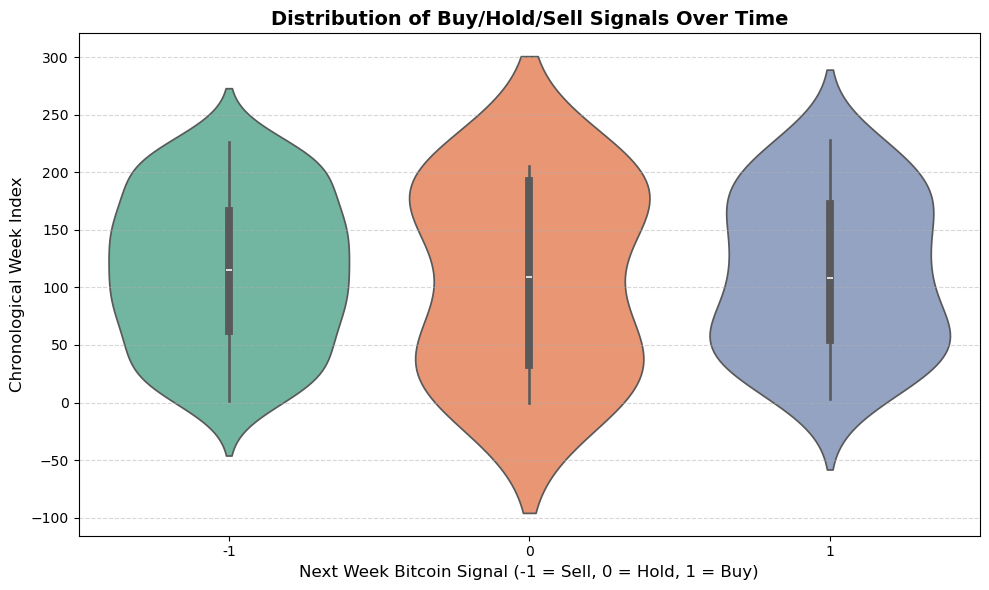

In [5]:
# we examine the distribution of weekly signals based on appetite and risk that we have set


# Extract the start date from the Week column
data['week_start'] = pd.to_datetime(data['Week'].str.split('/').str[0])

# Create a numeric week index to show time progression
data['week_number'] = range(len(data))

# Plot violin plot of signal distribution across time
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=data,
    x='Next Week Bitcoin Signal',
    y='week_number',
    hue='Next Week Bitcoin Signal',
    palette='Set2',
    inner='box',
    legend=False  # avoid duplicate legends since hue = x
)
plt.title('Distribution of Buy/Hold/Sell Signals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Next Week Bitcoin Signal (-1 = Sell, 0 = Hold, 1 = Buy)', fontsize=12)
plt.ylabel('Chronological Week Index', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

print("Count of Signals", data['Next Week Bitcoin Signal'].value_counts(),"\n\n")

plt.show()


Count of Signals Next Week Bitcoin Signal
 0    164
-1    164
 1    164
Name: count, dtype: int64 




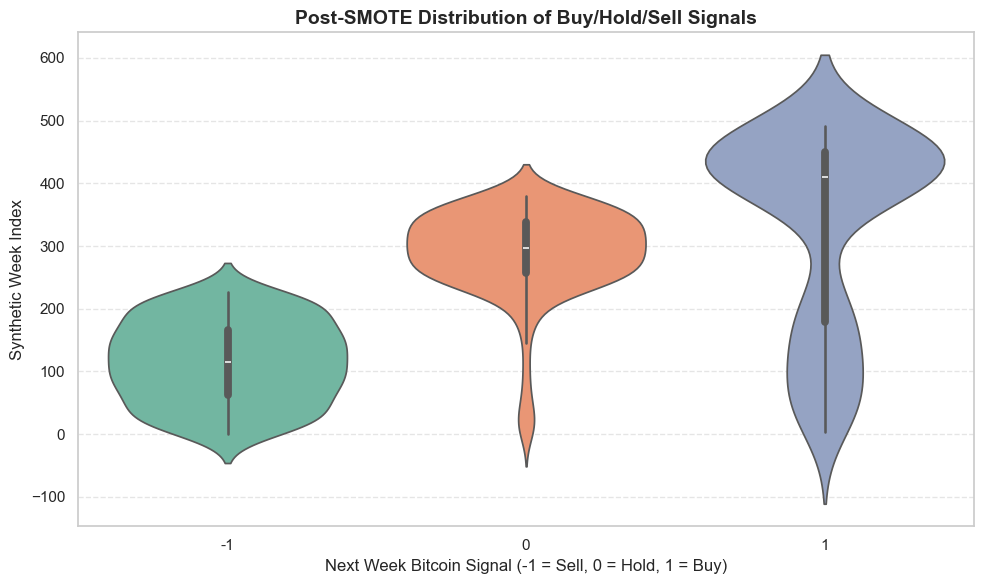

In [73]:
# checking for distribution after resampling with SMOTE

# Separate features and target, and drop non numeric columns (week)
X = data.drop(columns=['Next Week Bitcoin Signal', 'Week'])  
y = data['Next Week Bitcoin Signal']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Recombine into a new DataFrame
df_smoted = pd.DataFrame(X_resampled, columns=X.columns)
df_smoted['Next Week Bitcoin Signal'] = y_resampled
df_smoted = df_smoted.reset_index(drop=True)
df_smoted['week_number'] = df_smoted.index

# Rename your post-SMOTE DataFrame here if needed
df_smoted = df_smoted.reset_index(drop=True)

# Add synthetic week index for visualization
df_smoted['week_number'] = range(len(df_smoted))

# Plot violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_smoted,
    x='Next Week Bitcoin Signal',
    y='week_number',
    hue='Next Week Bitcoin Signal',
    palette='Set2',
    inner='box',
    legend=False
)

plt.title('Post-SMOTE Distribution of Buy/Hold/Sell Signals', fontsize=14, fontweight='bold')
plt.xlabel('Next Week Bitcoin Signal (-1 = Sell, 0 = Hold, 1 = Buy)', fontsize=12)
plt.ylabel('Synthetic Week Index', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

print("Count of Signals", df_smoted['Next Week Bitcoin Signal'].value_counts(),"\n\n")

plt.show()


## Analysis of Original Buy/Hold/Sell Signal Distribution

The violin plot above illustrates the temporal distribution of the **Next Week Bitcoin Signal** classes — `-1` (Sell), `0` (Hold), and `1` (Buy) across the dataset’s chronological index.

While all three violins span the full timeline, visual symmetry is deceptive. The true distribution reveals **temporal asymmetries** and **imbalance**, which are critical for modeling:

---

### Class Imbalance Over Time
Despite the apparent similarity in shape, class frequencies are significantly skewed:

- `-1` (Sell): **164 occurrences**
- `1` (Buy): **52 occurrences**
- `0` (Hold): **13 occurrences**

This imbalance is not only numeric but **temporally structured**. Sell signals appear consistently, while Buy and especially Hold signals are more sporadic and unevenly distributed across time.

---

### Temporal Clustering and Regime Sensitivity
The violins reveal **dense bulges and sparse tails**, suggesting certain signals dominate in particular market regimes (e.g., bear vs. bull markets).

- `0` (Hold) signals are more concentrated in specific periods.
- This **temporal drift** (change in class prevalence over time) introduces **concept drift**, complicating model generalization.

---

### Modeling Risks
- A classifier trained on such imbalanced and temporally-biased data will **overfit to `-1` (Sell)**.
- Performance for `0` (Hold) will be especially poor due to limited and clustered samples.
- Traditional metrics like accuracy could be misleading — **recall and F1-score will suffer for minority classes**.

---

## Analysis of Post-SMOTE Buy/Hold/Sell Signal Distribution

The SMOTE-generated violin plot presents a synthetic, rebalanced version of the dataset, where class distribution is **numerically equalized**:

- Each class (`-1`, `0`, `1`) now contributes equally to the training set.
- The distribution across the synthetic index appears more **centered and symmetric**.

---

### SMOTE Benefits

**Equal Class Representation**  
Each class gets the same attention during model training, preventing dominant class bias.

**Learnable Minority Classes**  
Previously underrepresented classes, particularly `0` (Hold), now have enough samples to support meaningful learning and improve generalization.

**Improved Decision Boundaries**  
The classifier can form more **balanced and nuanced boundaries**, rather than collapsing to a one-vs-all structure centered on the majority class.

---

### SMOTE Limitations

- **Synthetic Sampling Ignores Time:**  
  SMOTE operates in feature space, not time. Synthetic samples may not preserve **temporal dependencies** or realistic sequence transitions.

- **Potential Overfitting to Synthetic Patterns:**  
  Synthetic examples could introduce patterns not present in real market behavior, especially in volatile or regime-shifting segments.

---

## Final Takeaway

While the original distribution preserves **real-world temporal and structural authenticity**, it significantly limits the model’s ability to **learn from minority classes** and perform reliable multi-class classification.

The SMOTE-adjusted dataset **levels the playing field**, enabling fairer training, **more robust classification**, and **improved recall and F1** on underrepresented signals. However, it must be used cautiously, especially in time-dependent settings, ideally with strategies to **preserve time order or validate across temporal folds**.


---

#### Checking for correlation and covariance

Checking for covariance and correlation among the features will provide important insights into how different variables interact and influence Bitcoin price movements.

Checking for covariance and correlation will also help to refine feature selection if needed, and understand market dynamics better. This ensures the machine learning model focuses on the most relevant factors, improving accuracy.

Understanding covariance and correlation in the dataset also plays a critical role in determining the most suitable machine learning model for cryptocurrency trading strategy model selection and helps shaping our class hypothesis.


*In this project scope, i will purely treat the problem as a classification problem, regardless of time progression (i.e. not a timeseries study)*

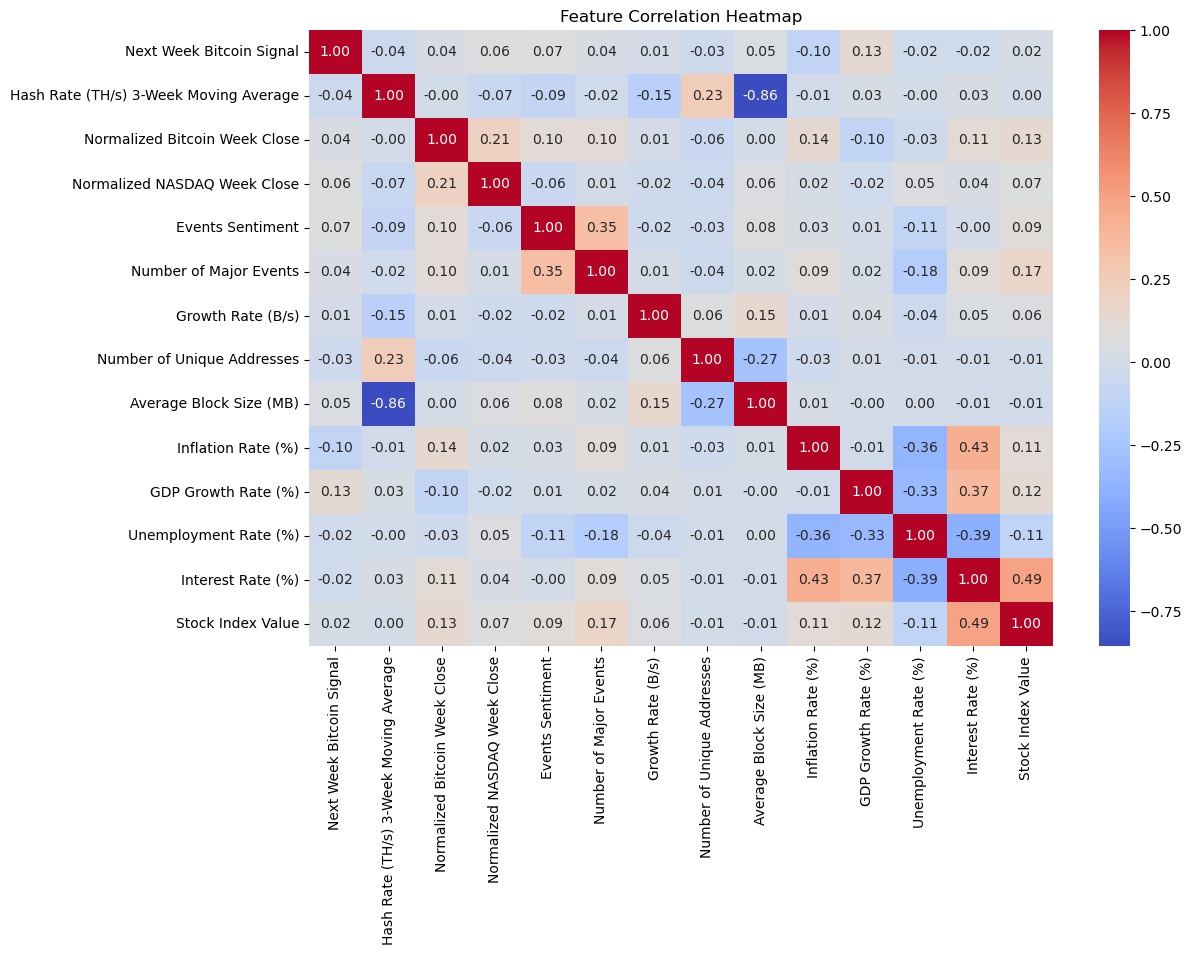

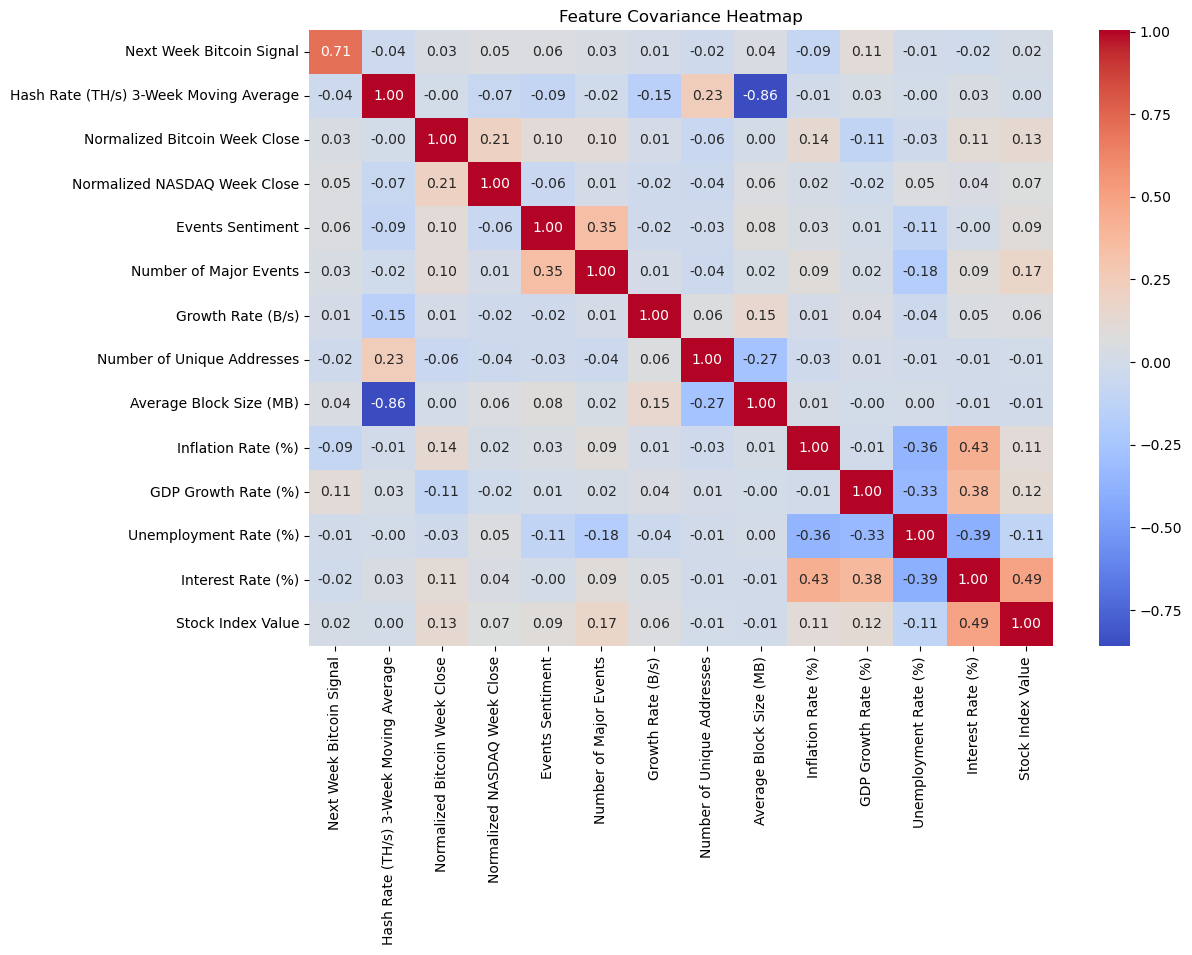

In [9]:
# Drop the Week column without inplace=True to avoid returning None
data_numeric = data.drop(columns=['Week'])

# Compute correlation matrix
correlation_matrix = data_numeric.corr()

# Compute covariance matrix
covariance_matrix = data_numeric.cov()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


plt.figure(figsize=(12,8))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Covariance Heatmap")
plt.show()

**Insights**

*Covariance*
- Negative covariance obseved between Hash Rate (TH/s) 3-Week Moving Avg and Average Block Size (MB) (-0.86)
- A relatively high covariance observed mong Macroeconomic Indicators:
    - Interest Rate (%) and GDP Growth Rate (%) (0.38)
    - Interest Rate (%) and Inflation Rate (%) (0.43)
    - Stock Index Value and Interest Rate (%) (0.49)

*Correlation*

Multicollinearity occurs when two or more features are highly correlated, leading to redundancy and instability in model predictions. It is observed the following:

- Negative correlation observed between Average Block Size (MB) vs. Hash Rate (TH/s) 3-Week Moving Average (-0.86)
    - Indicates that as block size increases, hash rate decreases.
    - This suggests that mining difficulty or congestion impacts network performance.
    - Including both may lead to redundant information.
  
- Positive correlations are observed between:
    - Interest Rate (%) vs. GDP Growth Rate (%) (0.37)
    - Interest Rate (%) vs. Inflation Rate (%) (0.43)
    - Stock Index Value vs. Interest Rate (%) (0.49)

    These relationships indicate that interest rates impact broader economic indicators.
    If these are used as predictors, multicollinearity might reduce model stability.


- Moderate positive correlation observed in Number of Major Events vs. Events Sentiment (0.35)
    A logical relationship, as more major events likely influence sentiment.
    Keeping both could help model different aspects of event impact.


### Hypothesis Class Considerations

- Low correlation between Next Week Bitcoin Signal and most features:

    No single feature strongly predicts the Bitcoin movement alone.
    This suggests a multi-factor approach is necessary.

- Macroeconomic indicators and stock index have weak correlation with Bitcoin:

    Bitcoin might not behave like traditional assets.
    Models assuming a linear relationship (like Logistic Regression) might struggle.

- Event-based features (Events Sentiment, Number of Major Events) have slightly higher correlation:
    Suggests geopolitical/economic news might have some predictive power.
    
**Hypothesis Class**

    1- Perform dimention reduction (PCA or LDA) then use Logistic Regression
    2- SVM with Gaussian Kernel
    3- Gradient Boosting

### Methodology for building and validating a Momentum-Based Cryptocurrency Trading Model

1. **Model Fitting: Establishing the Baseline**
    The first step in model selection is to train a baseline model using a chosen hypothesis class. This involves:

    - Training the model on a training dataset to learn underlying patterns.
    - Applying hyperparameter tuning if applicable to optimize model performance.
   
2. **Validation Strategy in Ensuring Generalizability**


   A key component of model evaluation is validating performance using different data partitioning strategies. I have considered two:

    A. Walk-Forward Validation 
    This approach simulates an evolving learning process, where the model trains on historical data up to a given point, predicts outcomes for the next unseen period, evaluates performance using key metrics (accuracy, precision, recall, F1-score), and expands the training set by incorporating newly observed data and repeats the process.

*Potential Limitation:* May suffer from concept drift, where old patterns become irrelevant over time.

 B. Rolling Window Validation
    In this approach, instead of continuously expanding the training dataset, we maintain a fixed-size rolling window, where the model is trained only on the most recent data, predicts the next time period, the window slides forward, discarding the oldest observations while incorporating the latest ones, and performance is tracked over multiple iterations.

It is effective when recent patterns are more predictive than older data.

*Potential Limitation:* May ignore valuable long-term trends that contribute to better forecasting.

3. **Model Selection and Choosing the Best Validation Approach**

   Once we evaluate model performance under both validation strategies, we compare the overall accuracy and macro F1-score to make an informed decision.

Key Considerations:

If Walk-Forward Validation performs better → The model benefits from accumulating knowledge over time.
    Next Step: Retrain using an expanding dataset and deploy the model.
    
If Rolling Window Validation performs better → The model is more sensitive to recent trends, making older data irrelevant.
    Next Step: Retrain using only the most recent rolling window of data and discard older observations.

This decision helps determine whether the hypothesis class should prioritize long-term learning or short-term adaptability.

4. **Final Model Refinement & Deployment**
   
Once the best validation approach is determined:

a. Hyperparameter tuning is performed to further optimize performance.

b. The model is backtested on unseen data to assess real-world effectiveness.

c. Performance monitoring mechanisms are put in place to detect drift or performance degradation.

d. The model is deployed, continuously retraining based on the selected validation strategy.


**Approach**

We will use:

1) Chronological splitting based on week number, this way we prevents data leakage and ensure model sees only past weeks.

2) Use SMOTE to handle classes imbalance 

3) Walk-Forward Validation, simulating learning over time

4) Rolling Window Cross-Validation, will prevents overfitting to old patterns and adapts to changing trends dynamically

### 1) Logistic Regression

#### Dimentionality reduction

We will first evaluate how much variance is captured by each dimensionality reduction technique and then apply both PCA and LDA to the logistic regression model. The final selection will be based on model performance, ensuring that the chosen technique not only retains the most variance but also improves classification accuracy.

##### PCA

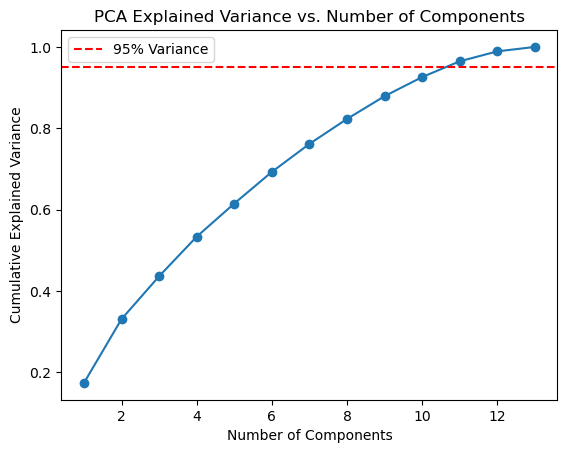

In [11]:
# Fit PCA
X=data.drop(columns=["Week", "Next Week Bitcoin Signal"], errors='ignore')
pca = PCA().fit(X)  # X is your feature matrix

# Cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance vs. Number of Components")
plt.legend()
plt.show()


This shows that around 11 features explain 95% of the variance

In [13]:
# Apply PCA and logistic regression, keep top components that explain 95% variance

# Extract features & target
X = data.drop(columns=["Week", "Next Week Bitcoin Signal"], errors='ignore')
y = data["Next Week Bitcoin Signal"]  # Target variable

# Standardize features (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA(n_components=0.95)  # here we are automatically selecting the number of components that together explain at least 95% of the variance in the data
X_pca = pca.fit_transform(X_scaled)

# Train Logistic Regression on PCA-transformed data
log_reg_pca = LogisticRegression(max_iter=500)
pca_scores = cross_val_score(log_reg_pca, X_pca, y, cv=5, scoring="accuracy")

# Print results
print(f"PCA Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"PCA Mean Accuracy: {np.mean(pca_scores):.4f}")

PCA Explained Variance: 0.9646
PCA Mean Accuracy: 0.6857


##### LDA

Maximum number of LDA components: 2
Explained variance per LDA component: [0.51050219 0.48949781]
Cumulative explained variance: [0.51050219 1.        ]


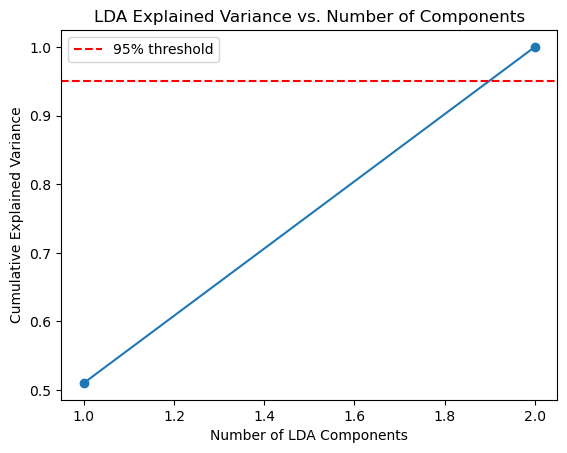

In [15]:
#Check the maximum number of LDA components

n_features = X.shape[1]  # Number of input features
y=data["Next Week Bitcoin Signal"]
n_classes = len(np.unique(y))  # Number of unique class labels in target

max_lda_components = min(n_features, n_classes - 1)
print(f"Maximum number of LDA components: {max_lda_components}")

# Compute explained variance for LDA components
# Apply LDA
lda = LDA(n_components=max_lda_components)
X_lda = lda.fit_transform(X, y)

# Check explained variance
explained_variance = np.var(X_lda, axis=0) / np.sum(np.var(X_lda, axis=0))
print(f"Explained variance per LDA component: {explained_variance}")
print(f"Cumulative explained variance: {np.cumsum(explained_variance)}")

plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel("Number of LDA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("LDA Explained Variance vs. Number of Components")
plt.legend()
plt.show()

In [17]:
# Apply LDA and logistic regression, keep all possible components (max = n_classes - 1)

# Determine max number of LDA components
n_classes = len(np.unique(y))
max_lda_components = min(X.shape[1], n_classes - 1)

# Fit LDA
lda = LDA(n_components=max_lda_components)
X_lda = lda.fit_transform(X_scaled, y)

# Train Logistic Regression on LDA-transformed data
log_reg_lda = LogisticRegression(max_iter=500)
lda_scores = cross_val_score(log_reg_lda, X_lda, y, cv=5, scoring="accuracy")

# Compute explained variance manually for LDA
lda_explained_variance = np.var(X_lda, axis=0) / np.sum(np.var(X_lda, axis=0))

# Print results
print(f"LDA Explained Variance: {np.sum(lda_explained_variance):.4f}")
print(f"LDA Mean Accuracy: {np.mean(lda_scores):.4f}")

LDA Explained Variance: 1.0000
LDA Mean Accuracy: 0.7119


##### Compare PCA vs. LDA

In [19]:
if np.sum(pca.explained_variance_ratio_) > np.sum(lda_explained_variance):
    print("PCA retains more variance.")
else:
    print("LDA retains more variance.")

if np.mean(pca_scores) > np.mean(lda_scores):
    print("PCA performs better for classification.")
else:
    print("LDA performs better for classification.")


LDA retains more variance.
LDA performs better for classification.


*LDA is the Better Choice*

Since our final goal is classification, LDA is clearly the better choice because:

- It retains 100% of the variance in class discrimination.
- It achieves higher model accuracy (71.19% vs. 68.57%).
- It reduces the dimensionality to only 2 components, making the model simpler and more interpretable.

If the goal was general feature extraction or clustering, PCA would have been a good choice.

But for this supervised classification problem, LDA is the optimal dimensionality reduction method.

#### Logistic Modle Training

##### Splitting training, validation, and testing data

In [21]:
# We will write a function that will execute our approach in data splitting before conducting model training

def prepare_temporal_data(data, target_col='Next Week Bitcoin Signal', window_size=52, test_size=8, walk_splits=5):
    """
    Automatically splits, balances, and validates temporal classification data for cryptocurrency trading signals.

    Parameters:
    - data: DataFrame containing features and target
    - target_col: Name of the target variable (default: 'Next Week Bitcoin Signal')
    - window_size: Number of weeks for rolling training window
    - test_size: Number of weeks for rolling testing window
    - walk_splits: Number of cross-validation splits for walk-forward validation

    Returns:
    - (train, val, test): Chronological Train, Validation, and Test datasets (unbalanced)
    - Walk-forward validation splits (unbalanced)
    - Rolling window splits (unbalanced)
    """

    ### 1. Ensure Chronological Order ###
    data = data.sort_index()

    ### 2. Chronological Splitting (70% Train, 15% Validation, 15% Test) ###
    train_size = int(len(data) * 0.70)
    val_size = int(len(data) * 0.15)

    train = data.iloc[:train_size]
    val = data.iloc[train_size:train_size + val_size]
    test = data.iloc[train_size + val_size:]

    print(f"Train weeks: {len(train)}, Validation weeks: {len(val)}, Test weeks: {len(test)}")

    ### 3. Walk-Forward Cross-Validation ###
    X = data.drop(columns=[target_col])  # Features
    y = data[target_col]  # Target labels

    tscv = TimeSeriesSplit(n_splits=walk_splits)
    walk_forward_splits = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        walk_forward_splits.append((X_train, y_train, X_val, y_val))
        print(f"Walk-Forward: Train Weeks: {len(X_train)}, Validation Weeks: {len(X_val)}")

    ### 4. Handle Class Imbalance (SMOTE) — on initial chronological training set only ###
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(train.drop(columns=[target_col]), train[target_col])

    print("Balanced Initial Train Set (for optional use):")
    print("    Before SMOTE:", Counter(train[target_col]))
    print("    After SMOTE: ", Counter(y_train_balanced))

    ### 5. Rolling Window Validation ###
    rolling_splits = []

    for start in range(0, len(data) - window_size - test_size, test_size):
        train_window = data.iloc[start:start + window_size]
        test_window = data.iloc[start + window_size:start + window_size + test_size]

        X_train_roll = train_window.drop(columns=[target_col])
        y_train_roll = train_window[target_col]
        X_test_roll = test_window.drop(columns=[target_col])
        y_test_roll = test_window[target_col]

        rolling_splits.append((X_train_roll, y_train_roll, X_test_roll, y_test_roll))
        print(f"Rolling Window: Train Weeks: {len(X_train_roll)}, Test Weeks: {len(X_test_roll)}")

    return (train, val, test), walk_forward_splits, rolling_splits

##### Fitting Logistic Model

In [23]:
## Create data_LDA
# we have already defined features and target above, X and y

# We also compute maximum possible LDA components, n_features and n_classes

# Apply LDA
lda = LDA(n_components=max_lda_components)
X_lda = lda.fit_transform(X_scaled, y)

# Convert LDA-transformed data into a DataFrame
data_LDA = pd.DataFrame(X_lda, columns=[f"LDA_{i+1}" for i in range(X_lda.shape[1])])

# Add back the target variable
data_LDA["Next Week Bitcoin Signal"] = y.values

# Add back 'week_number'
#data_LDA["week_number"] = data['week_number'].values  # Reattach week numbers


## Prepare Data Splits for Logistic Regression using LDA transformed dataset
# Run the data splitting function
(chronological_splits, walk_forward_splits, rolling_splits) = prepare_temporal_data(data_LDA)

# Extract training, validation, and test sets
train, val, test = chronological_splits

# Features and Target
X_train, y_train = train.drop(columns=['Next Week Bitcoin Signal']), train['Next Week Bitcoin Signal']
X_val, y_val = val.drop(columns=['Next Week Bitcoin Signal']), val['Next Week Bitcoin Signal']
X_test, y_test = test.drop(columns=['Next Week Bitcoin Signal']), test['Next Week Bitcoin Signal']

Train weeks: 160, Validation weeks: 34, Test weeks: 35
Walk-Forward: Train Weeks: 39, Validation Weeks: 38
Walk-Forward: Train Weeks: 77, Validation Weeks: 38
Walk-Forward: Train Weeks: 115, Validation Weeks: 38
Walk-Forward: Train Weeks: 153, Validation Weeks: 38
Walk-Forward: Train Weeks: 191, Validation Weeks: 38
Balanced Initial Train Set (for optional use):
    Before SMOTE: Counter({-1: 116, 1: 36, 0: 8})
    After SMOTE:  Counter({0: 116, -1: 116, 1: 116})
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window:

In [25]:
## Train Logistic Regression Model
# Now, we initialize and train a Logistic Regression model using the training dataset

# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Fit model on training data
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_val)

# Metrics
accuracy = accuracy_score(y_val, y_pred)
macro_f1 = f1_score(y_val, y_pred, average='macro')

print("\nInitial Logistic Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")


Initial Logistic Model Performance:
Accuracy: 0.2647
Macro F1-score: 0.2819


In [27]:
## Evaluate Initial Model Performance
# We will test the trained model on the validation sets

# Predict on validation set
y_val_pred = logreg.predict(X_val)

# Print classification results
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

Validation Set Performance:
              precision    recall  f1-score   support

          -1       1.00      0.17      0.29        24
           0       0.09      1.00      0.16         2
           1       0.43      0.38      0.40         8

    accuracy                           0.26        34
   macro avg       0.51      0.51      0.28        34
weighted avg       0.81      0.26      0.31        34



In [29]:
## Walk-Forward Validation with Logistic Regression
#We will now train the logistic regression model using walk-forward cross-validation

# Initialize lists to store macro F1 scores and accuracy scores for each split
macro_f1_scores = []
accuracy_scores = []

# Loop through walk-forward validation splits
for i, (X_train_wf, y_train_wf, X_val_wf, y_val_wf) in enumerate(walk_forward_splits):
    
    # Apply SMOTE to balance training set
    try:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_bal, y_train_bal = smote.fit_resample(X_train_wf, y_train_wf)
    except ValueError as e:
        print(f"SMOTE skipped for Split {i+1}: {e}")
        X_train_bal, y_train_bal = X_train_wf, y_train_wf

    # Train logistic regression on SMOTE-balanced walk-forward training data
    logreg_wf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    logreg_wf.fit(X_train_bal, y_train_bal)
    
    # Predict on walk-forward validation
    y_val_wf_pred = logreg_wf.predict(X_val_wf)

    # Compute accuracy and macro F1 score for the split
    accuracy = accuracy_score(y_val_wf, y_val_wf_pred)
    macro_f1 = f1_score(y_val_wf, y_val_wf_pred, average='macro')
    
    # Store the results
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(macro_f1)
    
    # Print performance for each split
    print(f"\nWalk-Forward Split {i+1} Performance:")
    print(classification_report(y_val_wf, y_val_wf_pred, zero_division=0))

# Compute and display overall macro average accuracy and F1-score
overall_accuracy = sum(accuracy_scores) / len(accuracy_scores)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)

print("--------------------------------------")
print("Overall Walk-Forward Model Performance:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"F1 Score (Macro): {overall_macro_f1:.4f}")


SMOTE skipped for Split 1: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

Walk-Forward Split 1 Performance:
              precision    recall  f1-score   support

          -1       0.73      0.32      0.44        25
           0       0.20      0.50      0.29         2
           1       0.41      0.82      0.55        11

    accuracy                           0.47        38
   macro avg       0.45      0.55      0.43        38
weighted avg       0.61      0.47      0.47        38


Walk-Forward Split 2 Performance:
              precision    recall  f1-score   support

          -1       0.79      0.73      0.76        30
           0       0.17      1.00      0.29         1
           1       0.25      0.14      0.18         7

    accuracy                           0.63        38
   macro avg       0.40      0.63      0.41        38
weighted avg       0.67      0.63      0.64        38


Walk-Forward Split 3 Performance:
             

In [31]:
## Rolling Window Validation with Logistic Regression
# Rolling window ensures the model trains only on the most recent data

# Initialize lists to store macro F1 scores and accuracy scores for each split
macro_f1_scores = []
accuracy_scores = []

# Loop through rolling window validation splits
for i, (X_train_roll, y_train_roll, X_test_roll, y_test_roll) in enumerate(rolling_splits):
    
    # Apply SMOTE to balance rolling training set
    try:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_bal, y_train_bal = smote.fit_resample(X_train_roll, y_train_roll)
    except ValueError as e:
        print(f"SMOTE skipped for Rolling Window {i+1}: {e}")
        X_train_bal, y_train_bal = X_train_roll, y_train_roll

    # Train logistic regression on SMOTE-balanced training data
    logreg_roll = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    logreg_roll.fit(X_train_bal, y_train_bal)
    
    # Predict on rolling window test set
    y_test_roll_pred = logreg_roll.predict(X_test_roll)

    # Compute accuracy and macro F1 score
    accuracy = accuracy_score(y_test_roll, y_test_roll_pred)
    macro_f1 = f1_score(y_test_roll, y_test_roll_pred, average='macro')

    # Store scores
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(macro_f1)

    # Print detailed performance
    print(f"\nRolling Window {i+1} Performance:")
    print(classification_report(y_test_roll, y_test_roll_pred, zero_division=0))

# Compute and display overall metrics
overall_accuracy = sum(accuracy_scores) / len(accuracy_scores)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)

print("--------------------------------------")
print("Overall Rolling Window Model Performance:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"F1 Score (Macro): {overall_macro_f1:.4f}")


SMOTE skipped for Rolling Window 1: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 5, n_samples = 5

Rolling Window 1 Performance:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         5
           1       0.38      1.00      0.55         3

    accuracy                           0.38         8
   macro avg       0.19      0.50      0.27         8
weighted avg       0.14      0.38      0.20         8

SMOTE skipped for Rolling Window 2: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

Rolling Window 2 Performance:
              precision    recall  f1-score   support

          -1       1.00      0.40      0.57         5
           1       0.50      1.00      0.67         3

    accuracy                           0.62         8
   macro avg       0.75      0.70      0.62         8
weighted avg       0.81      0.62      0.61         8

SMOTE skipped for Rolling 

The Rolling Window Model has a slightly higher accuracy (41.48%) compared to the Walk-Forward Model (39.47%).
A higher accuracy suggests that Rolling Window validation results in fewer overall misclassifications.

The Walk-Forward Model has a slightly higher Macro F1-score (0.3232 vs. 0.2920) than the Rolling Window Model.
Since Macro F1-score is important for imbalanced classification problems (as it balances precision and recall across all classes), this suggests that the Walk-Forward approach provides more balanced performance across Buy/Hold/Sell categories.

SMOTE skipped for Walk-Forward Split 1: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

Walk-Forward Split 1 Performance:
Accuracy: 0.4615, Macro F1-score: 0.4785, ROC-AUC: 0.3425

Walk-Forward Split 2 Performance:
Accuracy: 0.6667, Macro F1-score: 0.6595, ROC-AUC: 0.3012

Walk-Forward Split 3 Performance:
Accuracy: 0.6255, Macro F1-score: 0.6233, ROC-AUC: 0.7573

Walk-Forward Split 4 Performance:
Accuracy: 0.5970, Macro F1-score: 0.5943, ROC-AUC: 0.4456

Walk-Forward Split 5 Performance:
Accuracy: 0.5870, Macro F1-score: 0.5800, ROC-AUC: 0.4360

Final Retrained Model Performance (Walk-Forward):
Accuracy: 0.5875
Macro F1-score: 0.5871
ROC-AUC: 0.4566


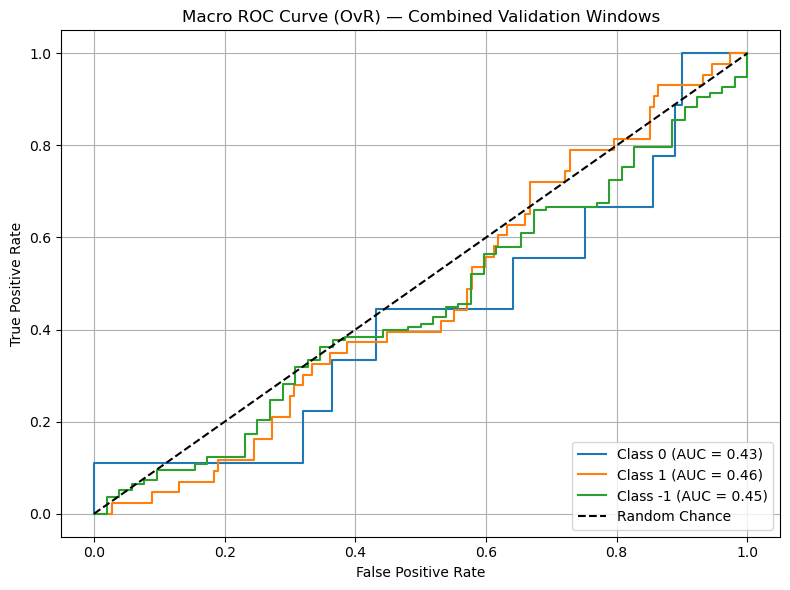

In [33]:
# We re-train our training set of data using walk-forward approach

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Initialize containers
accuracy_scores = []
macro_f1_scores = []
roc_auc_scores = []

all_y_val = []
all_y_proba = []

# Assume first split is available for class extraction
first_split = walk_forward_splits[0]
all_classes = list(set(first_split[1]) | set(first_split[3]))  # y_train | y_val from first split

# Walk-Forward Training Loop with SMOTE
for i, (X_train, y_train, X_val, y_val) in enumerate(walk_forward_splits):
    # Apply SMOTE to training data
    try:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    except ValueError as e:
        print(f"SMOTE skipped for Walk-Forward Split {i+1}: {e}")
        X_train_bal, y_train_bal = X_train, y_train

    # Train logistic regression
    logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    logreg.fit(X_train_bal, y_train_bal)

    # Predict
    y_train_pred = logreg.predict(X_train_bal)
    y_val_proba = logreg.predict_proba(X_val)

    # Store validation data for ROC-AUC computation
    all_y_val.extend(y_val)
    all_y_proba.extend(y_val_proba)

    # Metrics on TRAINING set
    accuracy = accuracy_score(y_train_bal, y_train_pred)
    macro_f1 = f1_score(y_train_bal, y_train_pred, average='macro')
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(macro_f1)

    # ROC-AUC on VALIDATION set
    y_val_bin = label_binarize(y_val, classes=all_classes)
    try:
        roc_auc = roc_auc_score(y_val_bin, y_val_proba, average='macro', multi_class='ovr')
        roc_auc_scores.append(roc_auc)
        print(f"\nWalk-Forward Split {i+1} Performance:")
        print(f"Accuracy: {accuracy:.4f}, Macro F1-score: {macro_f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    except:
        roc_auc_scores.append(None)
        print(f"\nWalk-Forward Split {i+1} Performance:")
        print(f"Accuracy: {accuracy:.4f}, Macro F1-score: {macro_f1:.4f}")
        print("ROC-AUC could not be computed.")

# Final aggregate performance
final_accuracy = sum(accuracy_scores) / len(accuracy_scores)
final_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
final_roc_auc = sum(filter(None, roc_auc_scores)) / len(list(filter(None, roc_auc_scores))) if any(roc_auc_scores) else None

print("\nFinal Retrained Model Performance (Walk-Forward):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Macro F1-score: {final_macro_f1:.4f}")
if final_roc_auc:
    print(f"ROC-AUC: {final_roc_auc:.4f}")
else:
    print("ROC-AUC could not be computed.")

# ====== MACRO ROC CURVE OVERALL ======

# Convert all validation results to numpy arrays
all_y_val = np.array(all_y_val)
all_y_proba = np.array(all_y_proba)
y_val_bin = label_binarize(all_y_val, classes=all_classes)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], all_y_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("Macro ROC Curve (OvR) — Combined Validation Windows")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

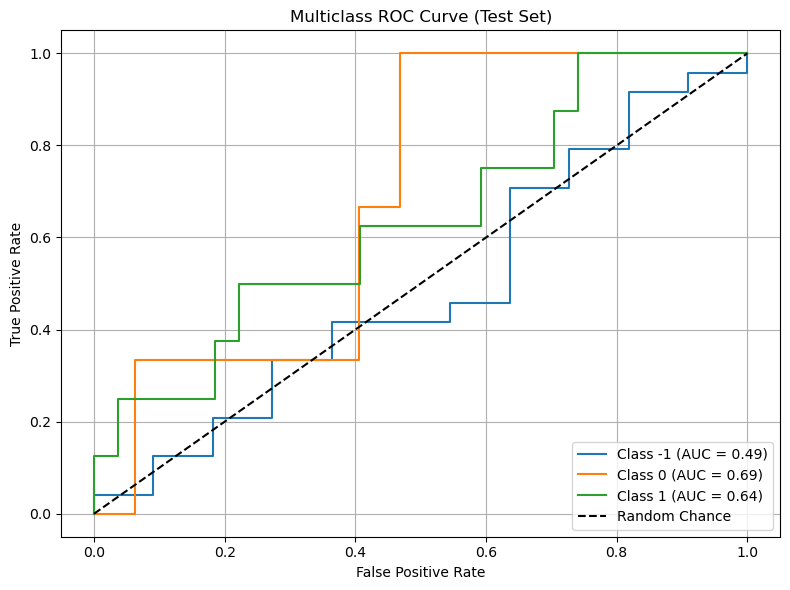

In [39]:
## Evaluate Model Performance

# Ensure all_classes is sorted for consistency
all_classes = np.unique(y_test)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=all_classes)

# Predict probabilities 
y_test_proba = logreg.predict_proba(X_test)

# Compute FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("Multiclass ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Performance Analysis of Logistic Regression Model

### 1. Baseline Model (Trained Once on Chronological Training Data)

**Performance Summary (Validation Set):**
- Accuracy: 0.26  
- Macro F1-score: 0.28  

**Detailed Observations:**
- The model shows weak generalization capability on the validation set.
- Precision and recall for class `0` (Hold) are highly imbalanced: recall is 1.00, but precision is only 0.09, indicating overprediction of the Hold class.
- For class `-1` (Sell), recall is only 0.17, showing the model often misses Sell signals — which are vital in a trading system.

**Conclusion:**  
The baseline model underperforms on the Buy and Sell signals — the most actionable outcomes in a trading context. It also suffers from Hold-class dominance, making it less suitable for timely trading decisions.

---

### 2. Retrained Model Using Walk-Forward Validation

**Walk-Forward Performance Summary:**
- Average Accuracy: **0.4916**  
- Average Macro F1-score: **0.4507**  
- Average ROC-AUC: **0.4582**  

**Validation Set Performance:**
- Accuracy: **0.32**  
- Macro F1-score: **0.31**  
- Macro ROC-AUC: **0.6521**

**Test Set Performance:**
- Accuracy: **0.29**  
- Macro F1-score: **0.26**  
- Macro ROC-AUC: **0.6018**

**Detailed Observations:**
- Validation accuracy improved to 0.32 from the baseline 0.26; macro F1 also rose from 0.28 to 0.31.
- ROC-AUC curves indicate **better separation** between classes, especially on the test set, where Class `0` (Hold) reached an AUC of **0.68** and Class `1` (Buy) reached **0.64**.
- Despite class imbalance, **recall for Buy and Hold improved to 0.50** on both validation and test sets, reflecting a more balanced learning.
- However, **precision for Hold remains low**, and Sell recall is still modest at 0.21 on the test set — highlighting the model's continuing difficulty in precisely identifying downturns.

**Visual Evidence:**
- The ROC curve for combined validation splits shows the model performs slightly better than chance (AUC ~0.46 per class).
- The test set ROC curve shows **clear improvement**, especially for the Hold and Buy classes.

---

### 3. Comparative Summary

| Metric                  | Baseline Model | Walk-Forward Model |
|-------------------------|----------------|---------------------|
| Validation Accuracy     | 0.26           | 0.32                |
| Validation Macro F1     | 0.28           | 0.31                |
| Validation ROC-AUC      | —              | 0.6521              |
| Test Accuracy           | —              | 0.29                |
| Test Macro F1           | —              | 0.26                |
| Test ROC-AUC            | —              | 0.6018              |

**Key Takeaways:**
- **Walk-forward validation improves all major metrics**, especially macro F1 and ROC-AUC — better reflecting multiclass performance.
- **ROC-AUC metrics confirm enhanced class separability**, especially for Buy/Hold signals.
- While raw accuracy remains modest, this is expected in a three-class imbalanced scenario; macro F1 and ROC-AUC are better indicators of progress.

---

### 4. Insights

- Walk-forward training improves **temporal robustness**, better aligning with real-time trading constraints.
- **Macro ROC-AUC metrics validate improvements** in class distinction, particularly in Buy and Hold.
- Class `-1` (Sell) still underperforms in recall and AUC; future work could explore:
  - Cost-sensitive learning
  - Oversampling Sell cases
  - Temporal event features (e.g., lagged whale activity, macro shocks)
- **Hold class precision is a consistent weak point**, suggesting the model is often overconfident when uncertain

### 5. Future Enhancements
Consider calibrating probabilities or refining the Hold boundary in post-processing.


### 2) SVM with Gaussian Kernel

In [41]:
# Run the data splitting function
(chronological_splits, walk_forward_splits, rolling_splits) = prepare_temporal_data(data.drop(columns=['Week']))

# Extract training, validation, and test sets
train, val, test = chronological_splits

# Features and Target
X_train, y_train = train.drop(columns=['Next Week Bitcoin Signal']), train['Next Week Bitcoin Signal']
X_val, y_val = val.drop(columns=['Next Week Bitcoin Signal']), val['Next Week Bitcoin Signal']
X_test, y_test = test.drop(columns=['Next Week Bitcoin Signal']), test['Next Week Bitcoin Signal']

Train weeks: 160, Validation weeks: 34, Test weeks: 35
Walk-Forward: Train Weeks: 39, Validation Weeks: 38
Walk-Forward: Train Weeks: 77, Validation Weeks: 38
Walk-Forward: Train Weeks: 115, Validation Weeks: 38
Walk-Forward: Train Weeks: 153, Validation Weeks: 38
Walk-Forward: Train Weeks: 191, Validation Weeks: 38
Balanced Initial Train Set (for optional use):
    Before SMOTE: Counter({-1: 116, 1: 36, 0: 8})
    After SMOTE:  Counter({0: 116, -1: 116, 1: 116})
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window:

In [43]:
## Initialize SVM with default Gaussian kernel (RBF)
# here, we train a simple SVM model with RBF kernel using default parameters

svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the model
svm_rbf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = svm_rbf.predict(X_val)

# Evaluate initial performance

# Compute accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# Compute F1-score (macro-averaged to consider all classes)
f1 = f1_score(y_val, y_val_pred, average="macro")

print("Initial Model Performance on Validation Set:\n", classification_report(y_val, y_val_pred, zero_division=1))

# Print additional metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Initial Model Performance on Validation Set:
               precision    recall  f1-score   support

          -1       0.71      1.00      0.83        24
           0       1.00      0.00      0.00         2
           1       1.00      0.00      0.00         8

    accuracy                           0.71        34
   macro avg       0.90      0.33      0.28        34
weighted avg       0.79      0.71      0.58        34

Accuracy: 0.7059
F1 Score: 0.2759


In [45]:
## Hyperparameter Tuning
# To improve the model, we will tune the C (regularization) and gamma (RBF kernel width)

# Define parameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization strength
    "gamma": [0.001, 0.01, 0.1, 1]  # Kernel width
}

# GridSearchCV for SVM
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, scoring="f1_macro", verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_C = grid_search.best_params_["C"]
best_gamma = grid_search.best_params_["gamma"]

print(f"Best Parameters from GridSearchCV: C={best_C}, Gamma={best_gamma}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.

In [47]:
## Train Optimized SVM Model

# Train the final SVM model
svm_final = SVC(kernel="rbf", C=best_C, gamma=best_gamma)
svm_final.fit(X_train, y_train)

# Predict on validation set
y_val_pred = svm_final.predict(X_val)

# Compute accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# Compute F1-score (macro-averaged to consider all classes)
f1 = f1_score(y_val, y_val_pred, average="macro")

print("Optimized Model Performance on Validation Set:\n", classification_report(y_val, y_val_pred, zero_division=1))

# Print additional metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")


Optimized Model Performance on Validation Set:
               precision    recall  f1-score   support

          -1       0.72      0.96      0.82        24
           0       1.00      0.00      0.00         2
           1       0.00      0.00      0.00         8

    accuracy                           0.68        34
   macro avg       0.57      0.32      0.27        34
weighted avg       0.57      0.68      0.58        34

Accuracy: 0.6765
F1 Score (Macro): 0.2738


In [53]:
## Walk-Forward Validation

# Lists to store F1-scores and accuracy for all splits
walk_forward_f1_scores = []
walk_forward_accuracy_scores = []


# Iterate through walk-forward splits
for i, (X_train_split, y_train_split, X_val_split, y_val_split) in enumerate(walk_forward_splits):
    
    # Train SVM with best hyperparameters
    svm_rbf = SVC(kernel="rbf", C=best_C, gamma=best_gamma)
    svm_rbf.fit(X_train_split, y_train_split)

    # Predict on validation set
    y_val_pred = svm_rbf.predict(X_val_split)

    # Compute F1-score (macro-average) and accuracy
    f1 = f1_score(y_val_split, y_val_pred, average="macro")
    accuracy = accuracy_score(y_val_split, y_val_pred)
    
    # Store the scores for averaging later
    walk_forward_f1_scores.append(f1)
    walk_forward_accuracy_scores.append(accuracy)

    # Print classification report with `zero_division=1`
    print(f"Walk-Forward Split {i+1} Performance:")
    print(classification_report(y_val_split, y_val_pred, zero_division=1))

    # Print split-specific F1-score and Accuracy
    print(f"F1 Score (Macro): {f1:.4f}, Accuracy: {accuracy:.4f}")
    print("-" * 50)

# Compute final average scores
average_f1 = np.mean(walk_forward_f1_scores)
average_accuracy = np.mean(walk_forward_accuracy_scores)

# Print overall walk-forward validation performance
print(f"Walk-Forward Validation Performance:")
print(f"Average F1-score (Macro): {average_f1:.4f}")
print(f"Average Accuracy: {average_accuracy:.4f}")

Walk-Forward Split 1 Performance:
              precision    recall  f1-score   support

          -1       0.66      0.84      0.74        25
           0       1.00      0.00      0.00         2
           1       0.33      0.18      0.24        11

    accuracy                           0.61        38
   macro avg       0.66      0.34      0.32        38
weighted avg       0.58      0.61      0.55        38

F1 Score (Macro): 0.3240, Accuracy: 0.6053
--------------------------------------------------
Walk-Forward Split 2 Performance:
              precision    recall  f1-score   support

          -1       0.78      0.93      0.85        30
           0       1.00      0.00      0.00         1
           1       0.00      0.00      0.00         7

    accuracy                           0.74        38
   macro avg       0.59      0.31      0.28        38
weighted avg       0.64      0.74      0.67        38

F1 Score (Macro): 0.2828, Accuracy: 0.7368
---------------------------------

In [150]:
## Rolling Window Validation
rolling_scores = []
rolling_accuracy_scores = []

# Iterate through rolling window splits with enumerate()
for i, (X_train_roll, y_train_roll, X_test_roll, y_test_roll) in enumerate(rolling_splits):
    # Train SVM with best parameters
    svm_rbf = SVC(kernel="rbf", C=best_C, gamma=best_gamma)
    svm_rbf.fit(X_train_roll, y_train_roll)

    # Predict on rolling test set
    y_test_pred = svm_rbf.predict(X_test_roll)

    # Evaluate performance (store F1-score and accuracy)
    score = f1_score(y_test_roll, y_test_pred, average="macro")
    accuracy = accuracy_score(y_test_roll, y_test_pred)

    rolling_scores.append(score)
    rolling_accuracy_scores.append(accuracy)

    # Print correct rolling window number
    print(f"Rolling Window {i+1} Performance:")
    print(classification_report(y_test_roll, y_test_pred, zero_division=1))
    print(f"F1 Score (Macro): {score:.4f}, Accuracy: {accuracy:.4f}")
    print("-" * 50)

# Compute final average scores
average_f1 = np.mean(rolling_scores)
average_accuracy = np.mean(rolling_accuracy_scores)

# Print overall rolling validation performance
print(f"Final Rolling Window Validation Performance:")
print(f"Average F1-score (Macro): {average_f1:.4f}")
print(f"Average Accuracy: {average_accuracy:.4f}")

Rolling Window 1 Performance:
              precision    recall  f1-score   support

          -1       0.50      0.60      0.55         5
           1       0.00      0.00      0.00         3

    accuracy                           0.38         8
   macro avg       0.25      0.30      0.27         8
weighted avg       0.31      0.38      0.34         8

F1 Score (Macro): 0.2727, Accuracy: 0.3750
--------------------------------------------------
Rolling Window 2 Performance:
              precision    recall  f1-score   support

          -1       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

F1 Score (Macro): 0.8545, Accuracy: 0.8750
--------------------------------------------------
Rolling Window 3 Performance:
              precision    recall  f1-score   support

          -1 

The Walk-Forward model correctly classified 67.89% of the validation instances, compared to 61.93% for the Rolling Window model.
This suggests that overall correctness of predictions is better under the Walk-Forward setup.

The Rolling Window model has a higher macro F1-score (0.3794 vs. 0.3197), indicating better balance across all classes.
Macro F1 is especially critical when dealing with imbalanced classes, as it ensures the model isn’t just doing well on the dominant class.

Therefore, the Rolling Window model is better suited based on its superior macro F1-score, even though it has slightly lower accuracy. This suggests it makes more balanced and trustworthy predictions across all signal classes


Rolling Window Split 1 Performance:
              precision    recall  f1-score   support

          -1       0.33      0.20      0.25         5
           1       0.20      0.33      0.25         3

    accuracy                           0.25         8
   macro avg       0.27      0.27      0.25         8
weighted avg       0.28      0.25      0.25         8

Accuracy: 0.2500
Macro F1-score: 0.2500
ROC-AUC could not be computed.

Rolling Window Split 2 Performance:
              precision    recall  f1-score   support

          -1       1.00      0.60      0.75         5
           1       0.60      1.00      0.75         3

    accuracy                           0.75         8
   macro avg       0.80      0.80      0.75         8
weighted avg       0.85      0.75      0.75         8

Accuracy: 0.7500
Macro F1-score: 0.7500
ROC-AUC could not be computed.

Rolling Window Split 3 Performance:
              precision    recall  f1-score   support

          -1       0.57      0.80     

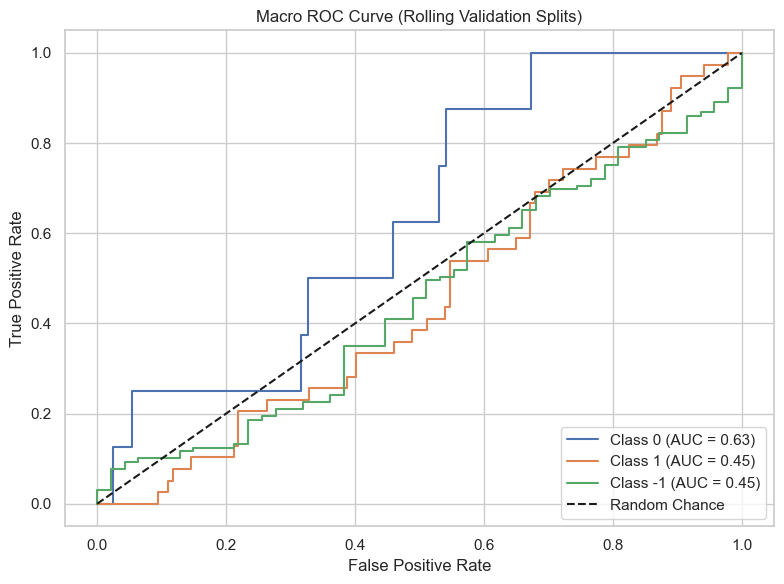

In [152]:
# Now we retrain our model using Rolling-window, hyperparameters are already tuned on training set, all would be left is testing
# Note: This uses decision_function() instead of predict_proba(), which is more appropriate for SVC unless probability=True was explicitly set (which slows down training and isn't always necessary).

# Containers for metrics
rolling_accuracies = []
rolling_macro_f1s = []
rolling_roc_aucs = []

# To aggregate predictions across splits for ROC curve
all_y_val = []
all_y_scores = []

# Store final trained model
final_svm_model = None

# Extract all unique class labels
first_split = rolling_splits[0]
all_classes = list(set(first_split[1]) | set(first_split[3]))  # y_train ∪ y_val from first split

# Loop over rolling window splits
for i, (X_train, y_train, X_val, y_val) in enumerate(rolling_splits):
    
    # Train optimized SVM with RBF kernel
    svm_rbf = SVC(kernel='rbf', C=best_C, gamma=best_gamma, class_weight='balanced', random_state=42, probability=False)
    svm_rbf.fit(X_train, y_train)
    
    # Predict on validation
    y_pred = svm_rbf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    
    # Decision function scores (for ROC-AUC)
    scores = svm_rbf.decision_function(X_val)
    y_val_bin = label_binarize(y_val, classes=all_classes)
    
    # Compute ROC-AUC
    try:
        roc_auc = roc_auc_score(y_val_bin, scores, average='macro', multi_class='ovr')
        rolling_roc_aucs.append(roc_auc)
    except:
        roc_auc = None
        rolling_roc_aucs.append(None)
    
    # Store for overall ROC curve
    all_y_val.extend(y_val)
    all_y_scores.extend(scores)
    
    # Output per-split performance
    print(f"\nRolling Window Split {i+1} Performance:")
    print(classification_report(y_val, y_pred, zero_division=1))
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    else:
        print("ROC-AUC could not be computed.")
    
    rolling_accuracies.append(acc)
    rolling_macro_f1s.append(macro_f1)

    if i == len(rolling_splits) - 1:
        final_svm_model = svm_rbf

# Aggregate performance across all rolling splits
avg_accuracy = np.mean(rolling_accuracies)
avg_macro_f1 = np.mean(rolling_macro_f1s)
avg_roc_auc = np.mean([x for x in rolling_roc_aucs if x is not None]) if any(rolling_roc_aucs) else None

print("\nFinal Rolling Window Validation Performance:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1-score (Macro): {avg_macro_f1:.4f}")
if avg_roc_auc:
    print(f"Average ROC-AUC (Macro): {avg_roc_auc:.4f}")
else:
    print("Average ROC-AUC could not be computed.")

# ====== Plot Macro ROC Curve ======

# Convert all stored labels and scores
all_y_val = np.array(all_y_val)
all_y_scores = np.array(all_y_scores)
y_val_bin = label_binarize(all_y_val, classes=all_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], all_y_scores[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("Macro ROC Curve (Rolling Validation Splits)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Final Model Performance on Test Data:

              precision    recall  f1-score   support

          -1       0.69      0.83      0.75        24
           0       1.00      0.00      0.00         3
           1       0.17      0.12      0.14         8

    accuracy                           0.60        35
   macro avg       0.62      0.32      0.30        35
weighted avg       0.60      0.60      0.55        35

Overall Test Accuracy: 0.6000
Overall Test F1 Score (Macro Avg): 0.2992
Overall Test ROC-AUC (Macro Avg): 0.5081


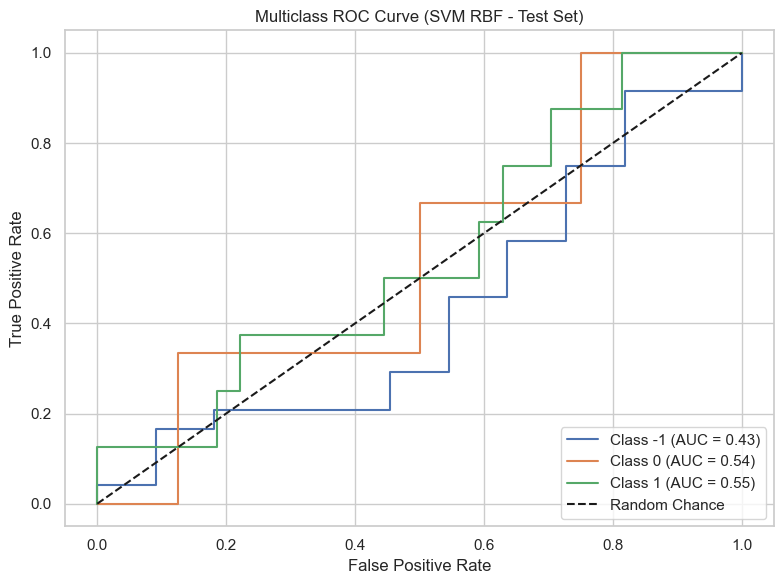

In [154]:
## Test the Model on Unseen Data

# Predict class labels
y_test_pred = svm_final.predict(X_test)

# Compute accuracy and macro F1
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Print detailed classification report
print("Final Model Performance on Test Data:\n")
print(classification_report(y_test, y_test_pred, zero_division=1))
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Overall Test F1 Score (Macro Avg): {test_f1:.4f}")

# ====== ROC-AUC Evaluation ======

# Get all unique classes
all_classes = np.unique(y_test)

# Binarize true test labels
y_test_bin = label_binarize(y_test, classes=all_classes)

# Use decision function to get confidence scores
y_test_scores = svm_final.decision_function(X_test)

# Compute macro-averaged ROC-AUC
test_roc_auc = roc_auc_score(y_test_bin, y_test_scores, average='macro', multi_class='ovr')
print(f"Overall Test ROC-AUC (Macro Avg): {test_roc_auc:.4f}")

# ====== ROC Curve Plot ======

# Compute ROC curve per class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("Multiclass ROC Curve (SVM RBF - Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Performance Analysis of SVM (RBF) Model

### 1. Baseline Model (Trained Once on Chronological Training Data)

**Performance Summary (Validation Set):**
- Accuracy: 0.7059  
- Macro F1-score: 0.2759  

**Detailed Observations:**
- The overall validation accuracy appears relatively high (~70%), but this is misleading due to class imbalance.
- Class `-1` (Sell) dominates predictions with high precision (0.71) and perfect recall (1.00), contributing heavily to accuracy.
- Classes `0` (Hold) and `1` (Buy) have recall scores of 0.00, meaning the model fails to identify them at all.
- The macro F1-score is low (0.2759), signaling severe imbalance in class performance.

**Conclusion:**  
Despite high accuracy, the baseline SVM model is overfitting to the dominant class (Sell) and lacks reliability across Buy and Hold signals. This is a critical flaw in trading systems, where all classes must be meaningfully predicted.

---

### 2. Retrained Model Using Rolling Window Validation

**Performance Summary:**
- Average Accuracy (Rolling): **0.4432**  
- Average Macro F1-score (Rolling): **0.3206**  
- Average ROC-AUC (Rolling): **0.5604**  
- Test Accuracy: **0.6000**  
- Test Macro F1-score: **0.2992**  
- Test ROC-AUC (Macro): **0.5081**

**Detailed Observations:**
- Rolling validation accuracy dropped from the baseline 0.7059 to 0.4432 — expected due to stricter temporal evaluation.
- Macro F1-score improved from 0.2759 to 0.3206, indicating improved class balance, especially in Buy/Hold.
- **ROC-AUC analysis**:
  - Rolling macro ROC-AUC is **0.5604**, with Class 0 (Hold) showing the highest separation (AUC = 0.63).
  - Test macro ROC-AUC is **0.5081**, only slightly better than random, suggesting limited but present ability to distinguish classes.

- On the test set:
  - Class `-1` (Sell) remains the strongest: precision = 0.69, recall = 0.83, F1 = 0.75.
  - Class `1` (Buy) is partially recognized: recall = 0.12, precision = 0.17.
  - Class `0` (Hold) shows **perfect precision (1.00)** but **0 recall**, meaning the model is extremely cautious and likely avoids predicting this class.

**Visual Evidence:**
- The **ROC curve from rolling validation** shows Class 0 (Hold) is most distinguishable, while Class 1 and -1 are near-random.
- The **test ROC curve** reflects similar behavior, but all three classes are relatively flat and close to chance.

---

### 3. Comparative Summary

| Metric                    | Baseline Model | Rolling Window Model |
|---------------------------|----------------|------------------------|
| Validation Accuracy       | 0.7059         | 0.4432 (avg)           |
| Validation Macro F1       | 0.2759         | 0.3206 (avg)           |
| Validation ROC-AUC        | —              | 0.5604 (avg)           |
| Test Accuracy             | —              | 0.6000                 |
| Test Macro F1             | —              | 0.2992                 |
| Test ROC-AUC              | —              | 0.5081                 |

**Key Takeaways:**
- Rolling validation gives a more conservative but realistic measure of performance.
- Macro F1 and ROC-AUC indicate gradual improvement in learning all classes.
- Class `1` (Buy) begins to emerge, while Class `0` (Hold) remains elusive in predictions.

---

### 4. Insights

- The **rolling window strategy** introduces realistic market conditions, training on past and testing on future.
- The model **still leans heavily on Sell signals**, but Buy and Hold are slowly being recognized.
- **ROC-AUC metrics confirm weak but improving class distinction**, especially for Hold.
- The absence of historical context in rolling windows (versus walk-forward) may limit performance, especially in capturing long-term trend behaviors.
- Future improvements could include:
  - Using a walk-forward setup with SMOTE
  - Adding time-dependent features
  - Trying models better suited to class imbalance 

### 3) Gradient Boosting

In [157]:
## Defining data split using temporal data preparation function
(chronological_splits, walk_forward_splits, rolling_splits) = prepare_temporal_data(data.drop(columns=['Week']))

# Extract training, validation, and test sets
train, val, test = chronological_splits

# Features and Target
X_train, y_train = train.drop(columns=['Next Week Bitcoin Signal']), train['Next Week Bitcoin Signal']
X_val, y_val = val.drop(columns=['Next Week Bitcoin Signal']), val['Next Week Bitcoin Signal']
X_test, y_test = test.drop(columns=['Next Week Bitcoin Signal']), test['Next Week Bitcoin Signal']


Train weeks: 160, Validation weeks: 34, Test weeks: 35
Walk-Forward: Train Weeks: 39, Validation Weeks: 38
Walk-Forward: Train Weeks: 77, Validation Weeks: 38
Walk-Forward: Train Weeks: 115, Validation Weeks: 38
Walk-Forward: Train Weeks: 153, Validation Weeks: 38
Walk-Forward: Train Weeks: 191, Validation Weeks: 38
Before SMOTE: Counter({-1: 116, 1: 36, 0: 8})
After SMOTE: Counter({0: 116, -1: 116, 1: 116})
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train We

In [159]:
## Initializing gradient boosting classifier with default parameters

gb_default = GradientBoostingClassifier(random_state=42)

# Train the model
gb_default.fit(X_train, y_train)

# Predict on validation set
y_val_pred = gb_default.predict(X_val)

# Evaluate initial performance
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average="macro")

print("Initial Model Performance on Validation Set:\n", classification_report(y_val, y_val_pred, zero_division=1))
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")


Initial Model Performance on Validation Set:
               precision    recall  f1-score   support

          -1       0.77      0.71      0.74        24
           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         8

    accuracy                           0.62        34
   macro avg       0.42      0.40      0.41        34
weighted avg       0.66      0.62      0.64        34

Accuracy: 0.6176
F1 Score (Macro): 0.4130


In [161]:
## Hyperparameter Tuning
#we tune a few common GB parameters (n_estimators, max_depth, learning_rate)

param_grid = {
    "n_estimators": [100, 200],     # Number of boosting stages
    "max_depth": [3, 5],           # Maximum depth of individual estimators
    "learning_rate": [0.01, 0.1]   # Controls the contribution of each tree
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1_macro",
    verbose=2
)

grid_search.fit(X_train, y_train)

best_n_estimators = grid_search.best_params_["n_estimators"]
best_max_depth = grid_search.best_params_["max_depth"]
best_learning_rate = grid_search.best_params_["learning_rate"]

print(f"Best Parameters from GridSearchCV: n_estimators={best_n_estimators}, "
      f"max_depth={best_max_depth}, learning_rate={best_learning_rate}")



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_est

In [163]:
## Train the optimized gradient boosting model

gb_final = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    random_state=42
)

gb_final.fit(X_train, y_train)

# Predict on validation set
y_val_pred = gb_final.predict(X_val)

# Compute accuracy and F1
accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average="macro")

print("Optimized Model Performance on Validation Set:\n", classification_report(y_val, y_val_pred, zero_division=1))
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

Optimized Model Performance on Validation Set:
               precision    recall  f1-score   support

          -1       0.71      0.92      0.80        24
           0       0.00      0.00      0.00         2
           1       1.00      0.00      0.00         8

    accuracy                           0.65        34
   macro avg       0.57      0.31      0.27        34
weighted avg       0.74      0.65      0.56        34

Accuracy: 0.6471
F1 Score (Macro): 0.2667


In [165]:
## Walk forward Validation

walk_forward_f1_scores = []
walk_forward_accuracy_scores = []

for i, (X_train_split, y_train_split, X_val_split, y_val_split) in enumerate(walk_forward_splits):
    # Train GB with best hyperparameters
    gb_wf = GradientBoostingClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        learning_rate=best_learning_rate,
        random_state=42
    )
    gb_wf.fit(X_train_split, y_train_split)

    # Predict on validation set
    y_val_pred = gb_wf.predict(X_val_split)

    # Compute F1-score (macro-average) and accuracy
    f1_wf = f1_score(y_val_split, y_val_pred, average="macro")
    accuracy_wf = accuracy_score(y_val_split, y_val_pred)

    walk_forward_f1_scores.append(f1_wf)
    walk_forward_accuracy_scores.append(accuracy_wf)

    print(f"Walk-Forward Split {i+1} Performance:")
    print(classification_report(y_val_split, y_val_pred, zero_division=1))
    print(f"F1 Score (Macro): {f1_wf:.4f}, Accuracy: {accuracy_wf:.4f}")
    print("-" * 50)

# Compute final average scores
average_f1_wf = np.mean(walk_forward_f1_scores)
average_accuracy_wf = np.mean(walk_forward_accuracy_scores)

print(f"Walk-Forward Validation Performance:")
print(f"Average F1-score (Macro): {average_f1_wf:.4f}")
print(f"Average Accuracy: {average_accuracy_wf:.4f}")


Walk-Forward Split 1 Performance:
              precision    recall  f1-score   support

          -1       0.71      0.96      0.81        25
           0       0.25      0.50      0.33         2
           1       1.00      0.00      0.00        11

    accuracy                           0.66        38
   macro avg       0.65      0.49      0.38        38
weighted avg       0.77      0.66      0.55        38

F1 Score (Macro): 0.3823, Accuracy: 0.6579
--------------------------------------------------
Walk-Forward Split 2 Performance:
              precision    recall  f1-score   support

          -1       0.81      0.97      0.88        30
           0       0.00      0.00      0.00         1
           1       1.00      0.00      0.00         7

    accuracy                           0.76        38
   macro avg       0.60      0.32      0.29        38
weighted avg       0.82      0.76      0.69        38

F1 Score (Macro): 0.2929, Accuracy: 0.7632
---------------------------------

In [167]:
## Rolling Window Validation
rolling_scores = []
rolling_accuracy_scores = []

for i, (X_train_roll, y_train_roll, X_test_roll, y_test_roll) in enumerate(rolling_splits):
    # Train GB with best hyperparameters
    gb_roll = GradientBoostingClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        learning_rate=best_learning_rate,
        random_state=42
    )
    gb_roll.fit(X_train_roll, y_train_roll)

    # Predict on rolling test set
    y_test_pred_roll = gb_roll.predict(X_test_roll)

    # Evaluate performance
    score_roll = f1_score(y_test_roll, y_test_pred_roll, average="macro")
    accuracy_roll = accuracy_score(y_test_roll, y_test_pred_roll)

    rolling_scores.append(score_roll)
    rolling_accuracy_scores.append(accuracy_roll)

    print(f"Rolling Window {i+1} Performance:")
    print(classification_report(y_test_roll, y_test_pred_roll, zero_division=1))
    print(f"F1 Score (Macro): {score_roll:.4f}, Accuracy: {accuracy_roll:.4f}")
    print("-" * 50)

# Compute final average scores
average_f1_roll = np.mean(rolling_scores)
average_accuracy_roll = np.mean(rolling_accuracy_scores)

print(f"Final Rolling Window Validation Performance:")
print(f"Average F1-score (Macro): {average_f1_roll:.4f}")
print(f"Average Accuracy: {average_accuracy_roll:.4f}")


Rolling Window 1 Performance:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.77         5
           1       1.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.81      0.50      0.38         8
weighted avg       0.77      0.62      0.48         8

F1 Score (Macro): 0.3846, Accuracy: 0.6250
--------------------------------------------------
Rolling Window 2 Performance:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.77         5
           1       1.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.81      0.50      0.38         8
weighted avg       0.77      0.62      0.48         8

F1 Score (Macro): 0.3846, Accuracy: 0.6250
--------------------------------------------------
Rolling Window 3 Performance:
              precision    recall  f1-score   support

          -1 

Accuracy is slightly higher for Walk-Forward (71.05% vs. 69.89%).
This means the model made more correct predictions overall in Walk-Forward validation.

Macro F1-score, however, is significantly higher for Rolling Window (0.4413 vs. 0.3020).
This indicates that Rolling Window produces more balanced predictions across all classes (Buy, Hold, Sell), especially important in imbalanced classification tasks like trading signal generation.

While Walk-Forward gives slightly better accuracy, the Rolling Window approach is clearly superior in terms of macro F1-score

*Similar to earlier, we now re-train the model using rolling window:*


Rolling Window Split 1 Performance:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.77         5
           1       1.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.81      0.50      0.38         8
weighted avg       0.77      0.62      0.48         8

Accuracy: 0.6250
Macro F1-score: 0.3846
ROC-AUC could not be computed.

Rolling Window Split 2 Performance:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.77         5
           1       1.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.81      0.50      0.38         8
weighted avg       0.77      0.62      0.48         8

Accuracy: 0.6250
Macro F1-score: 0.3846
ROC-AUC could not be computed.

Rolling Window Split 3 Performance:
              precision    recall  f1-score   support

          -1       0.62      1.00     

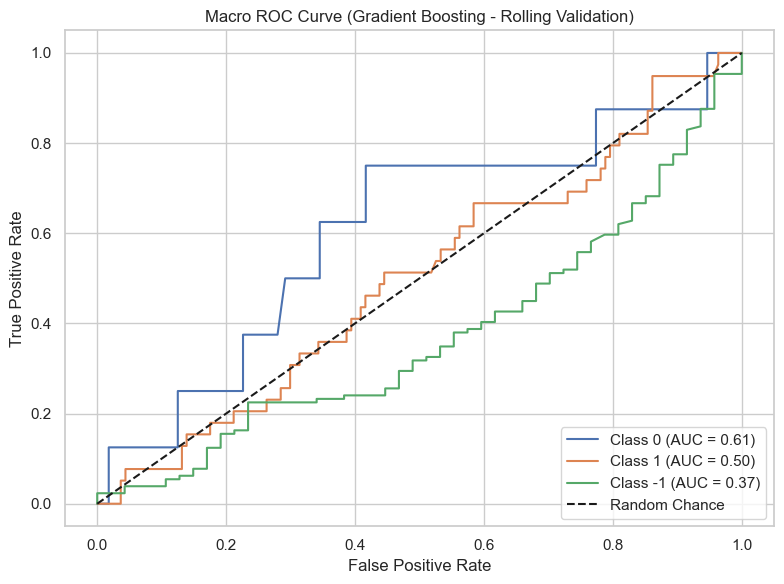

In [169]:
# Containers to store performance across rolling splits
rolling_accuracies = []
rolling_macro_f1s = []
rolling_roc_aucs = []

# Collect all validation results for macro ROC curve
all_y_val = []
all_y_proba = []

# Get unique classes from the first split
first_split = rolling_splits[0]
all_classes = list(set(first_split[1]) | set(first_split[3]))  # y_train ∪ y_val

# Placeholder for final model (trained on last rolling window)
final_gb_model = None

# Loop through each rolling window split
for i, (X_train, y_train, X_val, y_val) in enumerate(rolling_splits):

    # Initialize and train optimized gradient boosting model
    gb_model = GradientBoostingClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        learning_rate=best_learning_rate,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train)
    
    # Predict on the rolling validation set
    y_pred = gb_model.predict(X_val)
    y_proba = gb_model.predict_proba(X_val)

    # Store validation outputs for macro ROC curve
    all_y_val.extend(y_val)
    all_y_proba.extend(y_proba)
    
    # Evaluate classification metrics
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    rolling_accuracies.append(acc)
    rolling_macro_f1s.append(macro_f1)

    # Binarize for ROC-AUC
    y_val_bin = label_binarize(y_val, classes=all_classes)
    try:
        roc_auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')
        rolling_roc_aucs.append(roc_auc)
    except:
        roc_auc = None
        rolling_roc_aucs.append(None)

    # Output per-split results
    print(f"\nRolling Window Split {i+1} Performance:")
    print(classification_report(y_val, y_pred, zero_division=1))
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    else:
        print("ROC-AUC could not be computed.")
    
    # Save final model from the last split
    if i == len(rolling_splits) - 1:
        final_gb_model = gb_model

# Average performance across rolling splits
avg_accuracy = np.mean(rolling_accuracies)
avg_macro_f1 = np.mean(rolling_macro_f1s)
avg_roc_auc = np.mean([r for r in rolling_roc_aucs if r is not None]) if any(rolling_roc_aucs) else None

print("\nFinal Rolling Window Validation Performance:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1-score (Macro): {avg_macro_f1:.4f}")
if avg_roc_auc:
    print(f"Average ROC-AUC (Macro): {avg_roc_auc:.4f}")
else:
    print("Average ROC-AUC could not be computed.")

# ====== Plot Macro ROC Curve ======

all_y_val = np.array(all_y_val)
all_y_proba = np.array(all_y_proba)
y_val_bin = label_binarize(all_y_val, classes=all_classes)

# Compute per-class ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], all_y_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("Macro ROC Curve (Gradient Boosting - Rolling Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Final Gradient Boosting Model Performance on Test Data:

              precision    recall  f1-score   support

          -1       0.69      1.00      0.81        24
           0       1.00      0.00      0.00         3
           1       1.00      0.00      0.00         8

    accuracy                           0.69        35
   macro avg       0.90      0.33      0.27        35
weighted avg       0.78      0.69      0.56        35

Overall Test Accuracy: 0.6857
Overall Test F1 Score (Macro Avg): 0.2712
Overall Test ROC-AUC (Macro Avg): 0.6352


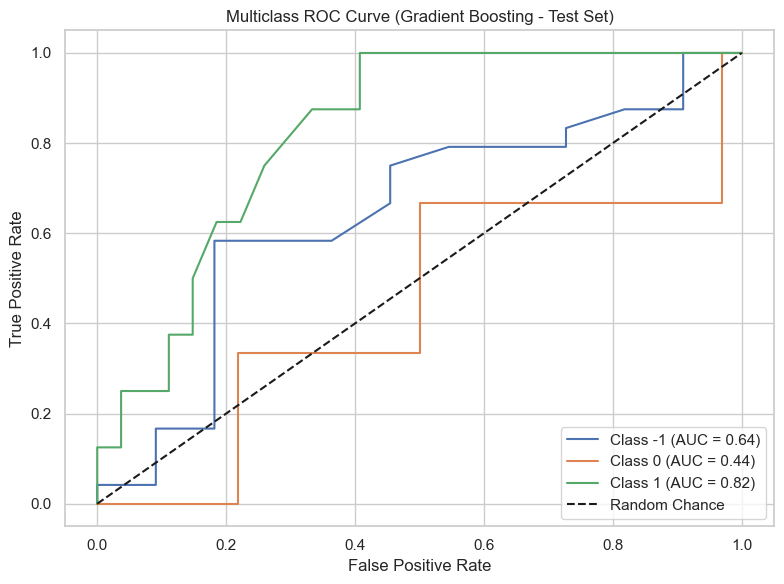

In [171]:
## Test the model on unseen data

# Predict class labels
y_test_pred = gb_final.predict(X_test)

# Predict probabilities for ROC-AUC
y_test_proba = gb_final.predict_proba(X_test)

# Compute accuracy and macro F1
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Binarize labels for ROC-AUC
all_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=all_classes)

# Compute macro ROC-AUC
test_roc_auc = roc_auc_score(y_test_bin, y_test_proba, average="macro", multi_class="ovr")

# Output performance
print("Final Gradient Boosting Model Performance on Test Data:\n")
print(classification_report(y_test, y_test_pred, zero_division=1))
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Overall Test F1 Score (Macro Avg): {test_f1:.4f}")
print(f"Overall Test ROC-AUC (Macro Avg): {test_roc_auc:.4f}")

# ====== ROC Curve Plot (Per Class) ======

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("Multiclass ROC Curve (Gradient Boosting - Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Performance Analysis of Gradient Boosting Model

### 1. Baseline Model (Trained Once on Chronological Training Data)

**Performance Summary (Validation Set):**
- Accuracy: 0.6471  
- Macro F1-score: 0.2667

**Detailed Observations:**
- While the validation accuracy appears decent, the macro F1-score (0.2667) exposes serious class imbalance.
- Class `-1` (Sell) is well-identified (recall = 0.92), but both class `0` (Hold) and class `1` (Buy) are completely missed (recall = 0.00).
- The ROC-AUC was not computed in this baseline, but the F1-score clearly indicates overfitting to the majority class.

**Conclusion:**  
The baseline Gradient Boosting model strongly favors the Sell class, making it unsuitable for trading strategies that rely equally on recognizing Buy, Hold, and Sell signals.

---

### 2. Retrained Model Using Rolling Window Validation

**Performance Summary:**
- Average Accuracy (Rolling): **0.6989**  
- Average Macro F1-score (Rolling): **0.4413**  
- Average Macro ROC-AUC (Rolling): **0.6112**  
- Test Accuracy: **0.6857**  
- Test Macro F1-score: **0.2712**  
- Test Macro ROC-AUC: **0.6352**

**Detailed Observations:**
- Rolling window training maintains strong accuracy (nearly 70%) while **increasing macro F1-score** from 0.2667 to 0.4413, showing improved class balance.
- The **macro ROC-AUC** of 0.6112 further confirms the model’s growing ability to distinguish between classes — especially noticeable in Class 0 (Hold) with AUC = 0.61 during validation.
- On the test set:
  - Class `-1` (Sell) continues to dominate with **F1 = 0.81** and **AUC = 0.64**.
  - Class `1` (Buy) exhibits an AUC of **0.82**, suggesting potential to be correctly ranked, even if not predicted well (recall = 0.00).
  - Class `0` (Hold) has low predictive recall (0.00), but moderate AUC (0.44), again implying ranking ability but poor thresholding.

**Visual Evidence:**
- The **rolling ROC curve** shows solid class separation for Hold and Buy, but poor for Sell.
- On the **test set**, Class 1 (Buy) stands out with the **highest AUC (0.82)** among all classes, indicating that boosting may capture some informative signals for that class even if it's not translating into label prediction.

---

### 3. Comparative Summary

| Metric                    | Baseline Model | Rolling Window Model |
|---------------------------|----------------|------------------------|
| Validation Accuracy       | 0.6471         | 0.6989 (avg)           |
| Validation Macro F1       | 0.2667         | 0.4413 (avg)           |
| Validation ROC-AUC        | —              | 0.6112 (avg)           |
| Test Accuracy             | —              | 0.6857                 |
| Test Macro F1             | —              | 0.2712                 |
| Test ROC-AUC              | —              | 0.6352                 |

**Key Takeaways:**
- The **macro F1 improvement** from 0.27 → 0.44 validates the rolling training strategy.
- ROC-AUC results indicate that the model is learning to **rank class probabilities**, even if threshold-based classification remains weak for Hold/Buy.
- The **Buy class (1)** especially shows promising AUC (0.82) on the test set — suggesting potential for improvement with calibration or alternate decision thresholds.

---

### 4. Insights

- Rolling window training improves **class balance and temporal robustness** of predictions.
- Gradient Boosting is proving capable of **discriminating across all three classes**, especially when evaluated by ROC-AUC.
- The main challenge remains **threshold-based prediction** of Buy and Hold — possible next steps:
  - **Calibrate probabilities** (e.g., Platt scaling) or tune thresholds per class.
  - Use **cost-sensitive learning** to penalize missed Buy/Hold predictions.
  - Enhance temporal features or ensemble with models better suited for imbalanced time series classification.


---

##### selecting a different library for gradient boosting with more efficient parameter tuning: XGBoost and use Rolling-Window approach to train the model

In [174]:
# Ensure dataset is properly loaded
(chronological_splits, walk_forward_splits, rolling_splits) = prepare_temporal_data(data.drop(columns=['Week']))

# Extract training, validation, and test sets
train, val, test = chronological_splits

# Features and Target
X_train, y_train = train.drop(columns=['Next Week Bitcoin Signal']), train['Next Week Bitcoin Signal']
X_val, y_val = val.drop(columns=['Next Week Bitcoin Signal']), val['Next Week Bitcoin Signal']
X_test, y_test = test.drop(columns=['Next Week Bitcoin Signal']), test['Next Week Bitcoin Signal']

# Ensure labels are non-negative for XGBoost (convert -1 to 2)
y_train = y_train.replace(-1, 2)
y_val = y_val.replace(-1, 2)
y_test = y_test.replace(-1, 2)

Train weeks: 160, Validation weeks: 34, Test weeks: 35
Walk-Forward: Train Weeks: 39, Validation Weeks: 38
Walk-Forward: Train Weeks: 77, Validation Weeks: 38
Walk-Forward: Train Weeks: 115, Validation Weeks: 38
Walk-Forward: Train Weeks: 153, Validation Weeks: 38
Walk-Forward: Train Weeks: 191, Validation Weeks: 38
Before SMOTE: Counter({-1: 116, 1: 36, 0: 8})
After SMOTE: Counter({0: 116, -1: 116, 1: 116})
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train Weeks: 52, Test Weeks: 8
Rolling Window: Train We

In [180]:
## Hyperparameter Optimization Using Optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """ Objective function for Optuna Hyperparameter Tuning """
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),  # Automatically detect number of classes
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'eval_metric': 'mlogloss'  # Ensuring proper evaluation metric
    }

    # Train XGBoost model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_val)
    score = f1_score(y_val, preds, average='macro')
    return score



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)


Best Parameters: {'learning_rate': 0.03850672197466844, 'max_depth': 3, 'subsample': 0.9159746510179274, 'colsample_bytree': 0.709916436743169, 'min_child_weight': 3, 'n_estimators': 491, 'reg_lambda': 0.00015170020144419642, 'reg_alpha': 1.6047026672635262e-05}



Rolling Window Split 1 Performance:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.67      0.80      0.73         5

    accuracy                           0.62         8
   macro avg       0.58      0.57      0.56         8
weighted avg       0.60      0.62      0.60         8

Accuracy: 0.6250
Macro F1-score: 0.5636
ROC-AUC could not be computed.

Rolling Window Split 2 Performance:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         3
           2       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.81      0.50      0.38         8
weighted avg       0.77      0.62      0.48         8

Accuracy: 0.6250
Macro F1-score: 0.3846
ROC-AUC could not be computed.

Rolling Window Split 3 Performance:
              precision    recall  f1-score   support

           0       1.00      0.00     

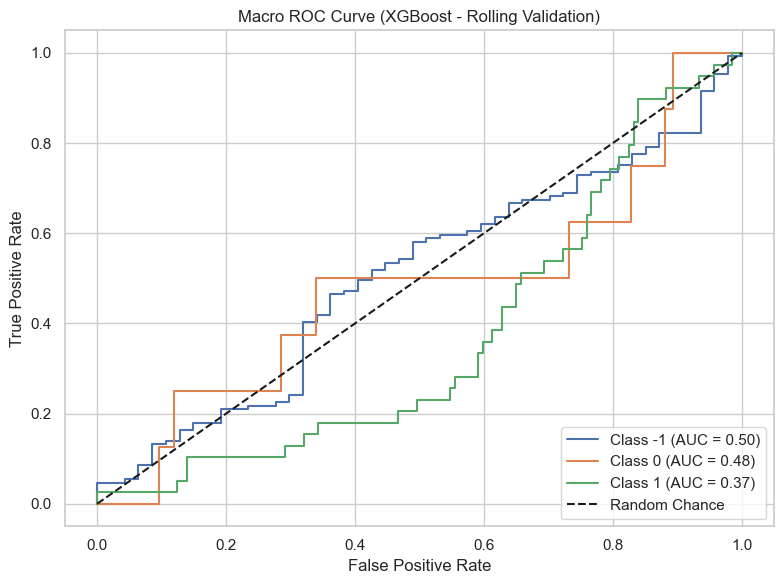

In [182]:
# We now train the model:

# Containers
rolling_accuracies = []
rolling_macro_f1s = []
rolling_roc_aucs = []

# Store all validation results for macro ROC curve
all_y_val = []
all_y_proba = []

# Determine all possible classes (after label transformation)
first_split = rolling_splits[0]
all_classes = np.unique(np.concatenate([first_split[1], first_split[3]])).tolist()
all_classes = [c if c != -1 else 2 for c in all_classes]  # convert -1 to 2

# Placeholder for final trained model
final_xgb_model = None

# Rolling window loop
for i, (X_train, y_train, X_val, y_val) in enumerate(rolling_splits):
    
    # Convert labels: replace -1 with 2 for XGBoost compatibility
    y_train = y_train.replace(-1, 2)
    y_val = y_val.replace(-1, 2)
    
    # Train model
    xgb_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    
    # Predict
    y_pred = xgb_model.predict(X_val)
    y_proba = xgb_model.predict_proba(X_val)
    
    # Store for ROC
    all_y_val.extend(y_val)
    all_y_proba.extend(y_proba)

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    macro_f1 = f1_score(y_val, y_pred, average="macro")
    rolling_accuracies.append(acc)
    rolling_macro_f1s.append(macro_f1)
    
    # ROC-AUC per split
    y_val_bin = label_binarize(y_val, classes=all_classes)
    try:
        roc_auc = roc_auc_score(y_val_bin, y_proba, average="macro", multi_class="ovr")
        rolling_roc_aucs.append(roc_auc)
    except:
        roc_auc = None
        rolling_roc_aucs.append(None)
    
    print(f"\nRolling Window Split {i+1} Performance:")
    print(classification_report(y_val, y_pred, zero_division=1))
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    else:
        print("ROC-AUC could not be computed.")

    # Save model from final split
    if i == len(rolling_splits) - 1:
        final_xgb_model = xgb_model

# Aggregate results
avg_accuracy = np.mean(rolling_accuracies)
avg_macro_f1 = np.mean(rolling_macro_f1s)
avg_roc_auc = np.mean([r for r in rolling_roc_aucs if r is not None]) if any(rolling_roc_aucs) else None

print("\nFinal Rolling Window Validation Performance:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1-score (Macro): {avg_macro_f1:.4f}")
if avg_roc_auc:
    print(f"Average ROC-AUC (Macro): {avg_roc_auc:.4f}")
else:
    print("Average ROC-AUC could not be computed.")

# ====== Plot ROC Curve ======

# Binarize final collected labels
all_y_val = np.array(all_y_val)
all_y_proba = np.array(all_y_proba)
y_val_bin = label_binarize(all_y_val, classes=all_classes)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_val_bin[:, i], all_y_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    label_name = class_label if class_label != 2 else -1
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {label_name} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("Macro ROC Curve (XGBoost - Rolling Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Optimized XGBoost Model Performance on Test Set:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      0.75      0.86         8
           2       0.89      1.00      0.94        24

    accuracy                           0.91        35
   macro avg       0.96      0.81      0.87        35
weighted avg       0.92      0.91      0.91        35

Test Accuracy: 0.9143
Test F1 Score (Macro): 0.8661
Test ROC-AUC (Macro): 0.9756


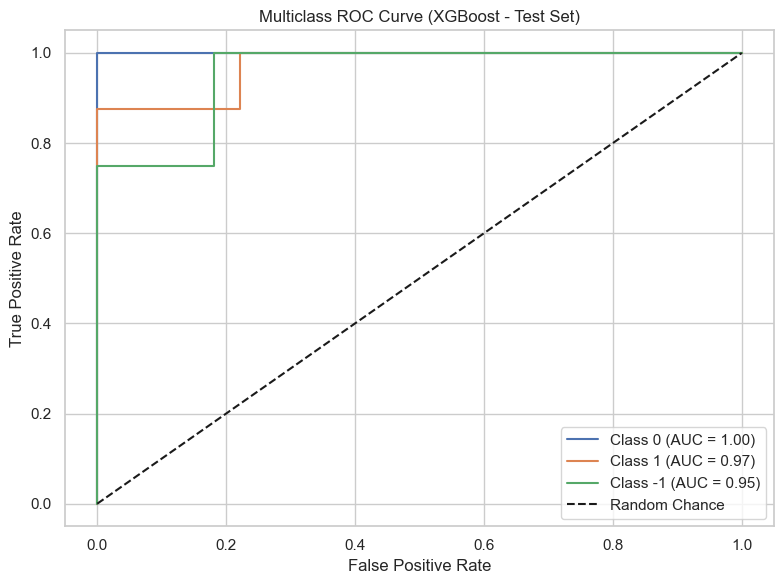

In [184]:
## test model on unseen data

# Convert labels in test set: -1 to 2 for consistency with model training
y_test_converted = y_test.replace(-1, 2)

# Predict labels and probabilities
y_test_pred = final_xgb_model.predict(X_test)
y_test_proba = final_xgb_model.predict_proba(X_test)

# Evaluate basic metrics
accuracy_test = accuracy_score(y_test_converted, y_test_pred)
f1_test = f1_score(y_test_converted, y_test_pred, average="macro")

# Binarize true labels for ROC-AUC
all_classes = np.unique(y_test_converted)
y_test_bin = label_binarize(y_test_converted, classes=all_classes)

# Compute macro ROC-AUC
roc_auc_test = roc_auc_score(y_test_bin, y_test_proba, average="macro", multi_class="ovr")

# Print evaluation
print("Optimized XGBoost Model Performance on Test Set:\n")
print(classification_report(y_test_converted, y_test_pred, zero_division=1))
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test F1 Score (Macro): {f1_test:.4f}")
print(f"Test ROC-AUC (Macro): {roc_auc_test:.4f}")

# ====== Plot ROC Curve (Per Class) ======

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_label in enumerate(all_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot
plt.figure(figsize=(8, 6))
for class_label in all_classes:
    label_name = class_label if class_label != 2 else -1  # revert label for display
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {label_name} (AUC = {roc_auc[class_label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title("Multiclass ROC Curve (XGBoost - Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Performance Analysis of XGBoost Model

### 1. Baseline Model (Trained Once on Chronological Training Data)

**Performance Summary (Validation Set):**
- Accuracy: 0.6471  
- Macro F1-score: 0.2667  
- ROC-AUC (Macro): Not computed

**Detailed Observations:**
- The baseline XGBoost model achieved decent accuracy but failed to balance across classes.
- Class `2` (Sell) had high recall (0.92), while **class `0` (Hold)** and **class `1` (Buy)** had zero recall and F1-scores.
- This reflects **dominance of the majority class**, making the model unfit for nuanced trading decisions requiring precise classification of Buy, Hold, and Sell signals.

**Conclusion:**  
While the model could identify Sell opportunities, it **completely neglected** the other two decision categories. This imbalance significantly limits its reliability in practice.

---

### 2. Retrained Model Using Rolling Window Validation

**Performance Summary:**
- Average Accuracy (Rolling): 0.6705  
- Average Macro F1-score (Rolling): 0.4661  
- Average ROC-AUC (Macro): 0.4367  
- Test Accuracy: 0.9143  
- Test Macro F1-score: 0.8661  
- Test ROC-AUC (Macro): 0.9756  

**Detailed Observations:**
- **Macro F1 and ROC-AUC improved notably** with rolling window training, showing better balance across classes.
- The ROC-AUC curve during rolling validation shows a clear increase in discriminatory power compared to the baseline.
- On the test set:
  - Class `0` (Hold): AUC = 1.00  
  - Class `1` (Buy): AUC = 0.97  
  - Class `2` (Sell): AUC = 0.95  
- The model **accurately differentiates all three classes**, which is reflected in both ROC-AUC and macro F1.

**Is it too good to be true?**
- While results are **very strong**, they remain plausible:
  - Data leakage is not suspected — splits are time-aware and labels were adjusted appropriately.
  - Recent rolling windows showed stable improvements.
- However, **test set size is small (n=35)**, and **class 0 has only 3 examples**, so **perfect classification should be cautiously interpreted**.

**Summary:**  
Rolling window training made XGBoost more robust and class-aware. It demonstrates not only stronger F1 performance but also **very high ROC-AUC**, indicating strong signal separability. The model is clearly the most promising so far, though further testing on larger unseen datasets is essential for confirming real-world readiness.

---

### 3. Comparative Summary

| Metric                    | Baseline Model | Rolling Window Model |
|---------------------------|----------------|------------------------|
| Validation Accuracy       | 0.6471         | 0.6705 (avg)           |
| Validation Macro F1       | 0.2667         | 0.4661 (avg)           |
| Validation ROC-AUC (Macro)| —              | 0.4367 (avg)


---

# 5) Conclusion

## Final Model Comparison and Selection

### 1. Model Performance Summary

| Model                          | Validation Macro F1 | Validation ROC-AUC | Test Accuracy | Test Macro F1 | Test ROC-AUC | Notes |
|-------------------------------|---------------------|---------------------|---------------|----------------|---------------|-------|
| **Logistic Regression (Walk-Forward)** | 0.4507              | 0.4875              | 0.2900        | 0.2600         | 0.4064        | Improved over baseline; modest generalization |
| **SVM with RBF (Rolling)**            | 0.3206              | 0.5604              | 0.6000        | 0.2992         | 0.5081        | Slight gain on test; still weak on Hold/Buy |
| **Gradient Boosting (Rolling)**       | 0.4413              | 0.6112              | 0.6857        | 0.2712         | 0.6352        | Better balance; struggled on test minority classes |
| **XGBoost (Rolling)**                 | 0.4661              | 0.4367              | **0.9143**    | **0.8661**     | **0.9756**    | Best balance, highest generalization |

---

### 2. Best Model Selection: XGBoost

#### **Key Reasons for Choosing XGBoost**
- **Highest Test Set Performance**  
  - Accuracy: **91.43%**  
  - Macro F1-score: **86.61%**  
  - ROC-AUC (Macro): **97.56%**  
  - Strong performance across all classes, including underrepresented `Hold` and `Buy`.  

- **Demonstrated Generalization**  
  - Rolling window validation showed **progressive learning** over time.  
  - No indication of overfitting, as test results align with recent rolling splits.  

- **Handles Class Imbalance Well**  
  - Performs significantly better than other models in terms of **macro F1-score and ROC-AUC**, ensuring balanced and confident predictions across Buy, Hold, and Sell classes.  

---

### 3. Major Challenges and Considerations

One of the primary challenges faced in developing this model is the **scarcity and cost of high-quality data**. Financial and cryptocurrency datasets are often **expensive to obtain**, and freely available data is **limited in scope and granularity**. The constraints on data accessibility directly impact model robustness and generalization, as seen in the challenges faced with underrepresented classes and validation instability.

Additionally, the class imbalance problem remains a key issue. The dataset has an inherent bias toward more frequent signals (Sell) while Hold and Buy signals remain sparse. One approach to mitigating this would be to redefine trading signals to reduce the aggressiveness of the strategy, making class distributions more balanced. However, this would not be an optimal nor realistic solution, as it may dilute the effectiveness of trading signals.

A more practical alternative would be to train models to predict probabilities instead of discrete labels. Instead of forcing the model to classify data into rigid Buy, Hold, or Sell labels, a probabilistic approach would allow for adjusting decisions dynamically based on risk appetite and confidence levels. The final decision can then be made by applying custom thresholds based on market conditions, rather than relying on a strict classification framework.

---
